In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
steel_initial = pd.read_csv("steel.csv")

In [93]:
# Первый взгляд на то, как выглядят данные
steel_initial.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V25,V26,V27,V28,V29,V30,V31,V32,V33,Class
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,1
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,1
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,1
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,1
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,1


In [94]:
# Расшифруем названия столбцов-признаков и столбцов-меток согласно описанию
long_column_names = {
    "V1": "X_Minimum",
    "V2": "X_Maximum",
    "V3": "Y_Minimum",
    "V4": "Y_Maximum",
    "V5": "Pixels_Areas",
    "V6": "X_Perimeter",
    "V7": "Y_Perimeter",
    "V8": "Sum_of_Luminosity",
    "V9": "Minimum_of_Luminosity",
    "V10": "Maximum_of_Luminosity",
    "V11": "Length_of_Conveyer",
    "V12": "TypeOfSteel_A300",
    "V13": "TypeOfSteel_A400",
    "V14": "Steel_Plate_Thickness",
    "V15": "Edges_Index",
    "V16": "Empty_Index",
    "V17": "Square_Index",
    "V18": "Outside_X_Index",
    "V19": "Edges_X_Index",
    "V20": "Edges_Y_Index",
    "V21": "Outside_Global_Index",
    "V22": "LogOfAreas",
    "V23": "Log_X_Index",
    "V24": "Log_Y_Index",
    "V25": "Orientation_Index",
    "V26": "Luminosity_Index",
    "V27": "SigmoidOfAreas",
    "V28": "Pastry",
    "V29": "Z_Scratch",
    "V30": "K_Scratch", #K_Scatch
    "V31": "Stains",
    "V32": "Dirtiness",
    "V33": "Bumps",
    "Class": "Other_Faults",
}

In [95]:
steel_long_names = steel_initial.rename(columns=long_column_names)

In [96]:
# Технический взгляд на загруженный датасет.
# NaN значений нет: Non-Null Count каждого столбца совпадает с обшей длиной датасета
# Для оптимизации исходного датасета можно вручную (метод astype) привести типы более строго согласно значениям, если заранее определена ОДЗ.
# Например float64 => float32, int => uint для беззнаковых или бинарных [0; 1] значений
steel_long_names.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [97]:
# Выделим непересекающуюся метку в отдельный столбец
steel_long_names["Other_Fault"] = pd.get_dummies(data=steel_long_names["Other_Faults"], prefix="Other_Faults")["Other_Faults_2"]

In [98]:
# Старый столбец с пересекающимися значениями удалим
steel_long_names.drop("Other_Faults", axis=1, inplace=True)

In [99]:
# Каждая метка y принадлежит одному наблюдению x - задача многоклассовой классификации без пересечения классов
steel_long_names[["Pastry", "Z_Scratch", "K_Scratch", "Stains", "Dirtiness", "Bumps", "Other_Fault"]].sum(axis=1).unique()

array([1], dtype=int64)

In [100]:
# Отдельно выделим столбцы-метки и столбцы-признаки
steel_labels = steel_long_names[["Pastry", "Z_Scratch", "K_Scratch", "Stains", "Dirtiness", "Bumps", "Other_Fault"]]
steel_features = steel_long_names[steel_long_names.columns.difference(steel_labels.columns)]

In [101]:
steel_labels.sum(axis=1).unique()

array([1], dtype=int64)

In [102]:
# Рассмотрим столбцы-признаки

In [103]:
def column_insight(column: pd.Series) -> None:
    fig, axs = plt.subplots(ncols=2)
    print(column.describe())
    print(f"Skewness: {column.skew()}")
    sns.histplot(x=column, ax=axs[0]) #
    sns.boxplot(x=column, ax=axs[1]) #
    return

In [104]:
# Настройки seaborn: увеличение размера графиков, увеличение размера шрифта на графиков
sns.set(rc={'figure.figsize':(24,12)})
sns.set(font_scale=1.25)

count    1941.000000
mean      571.136012
std       520.690671
min         0.000000
25%        51.000000
50%       435.000000
75%      1053.000000
max      1705.000000
Name: X_Minimum, dtype: float64
Skewness: 0.5008972035442011


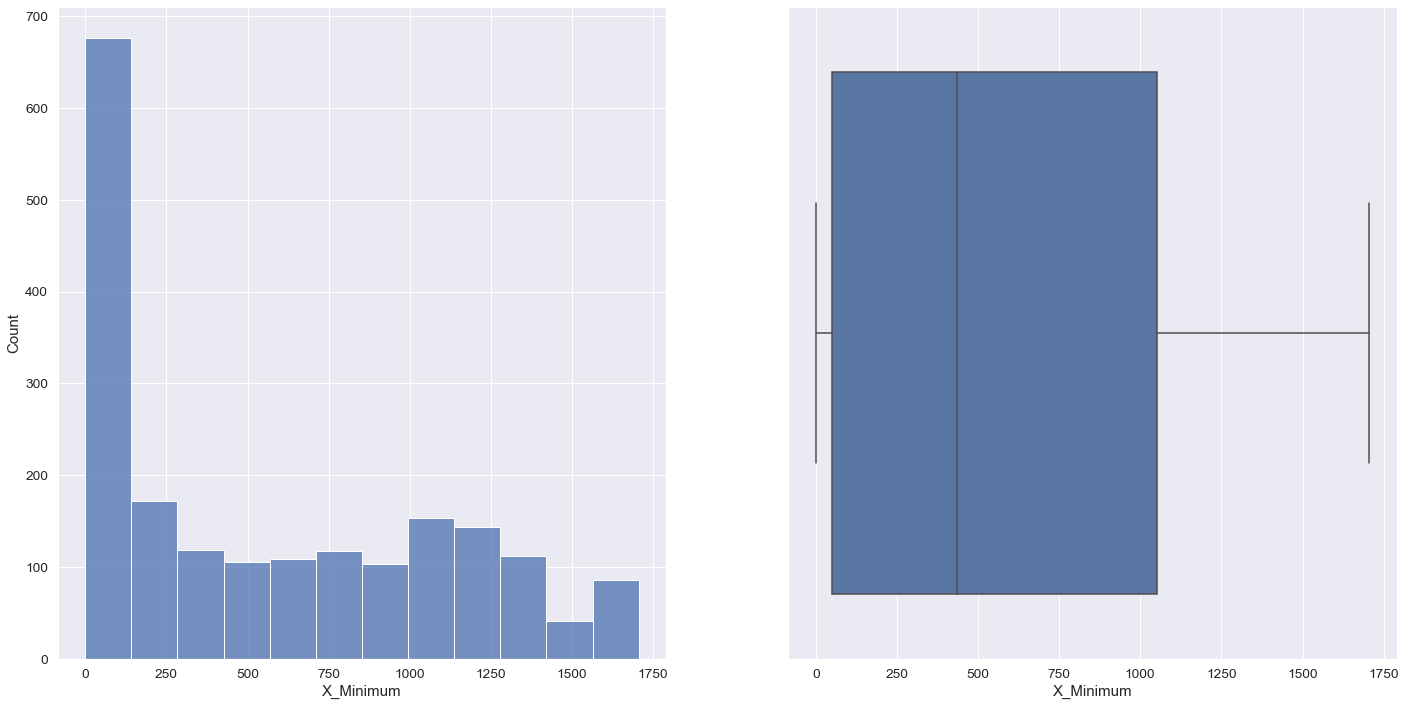

In [105]:
column_insight(steel_features["X_Minimum"])

In [106]:
# Судя по графику boxplot, аномальных значений нет.

count    1941.000000
mean      617.964451
std       497.627410
min         4.000000
25%       192.000000
50%       467.000000
75%      1072.000000
max      1713.000000
Name: X_Maximum, dtype: float64
Skewness: 0.5242096708816568


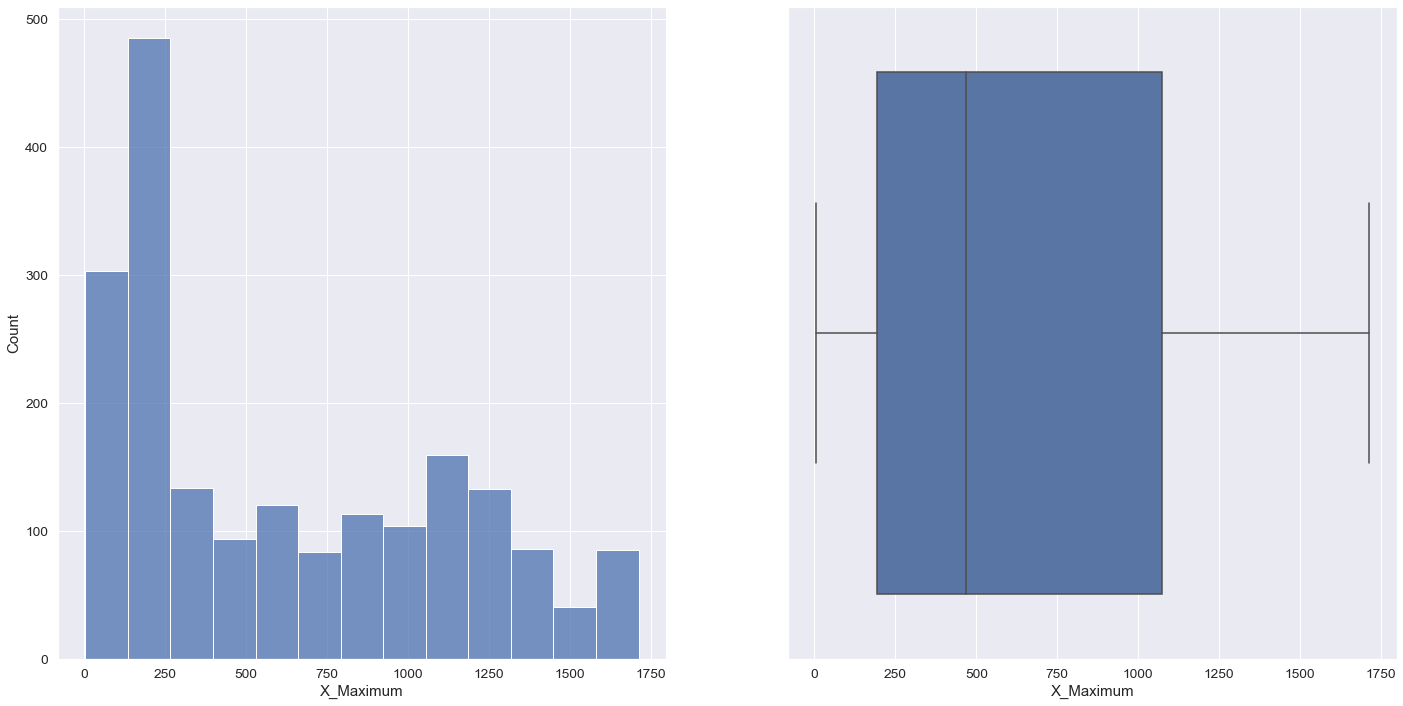

In [107]:
column_insight(steel_features["X_Maximum"])

In [108]:
# Распределение похоже на распределение X_Minimum

In [109]:
# X_Maximum имеет наибольшее количество значений в интервале [0; 250].

count    1941.000000
mean       46.828439
std        81.166933
min         2.000000
25%        10.000000
50%        15.000000
75%        33.000000
max      1186.000000
dtype: float64
Skewness: 5.1444185334085475


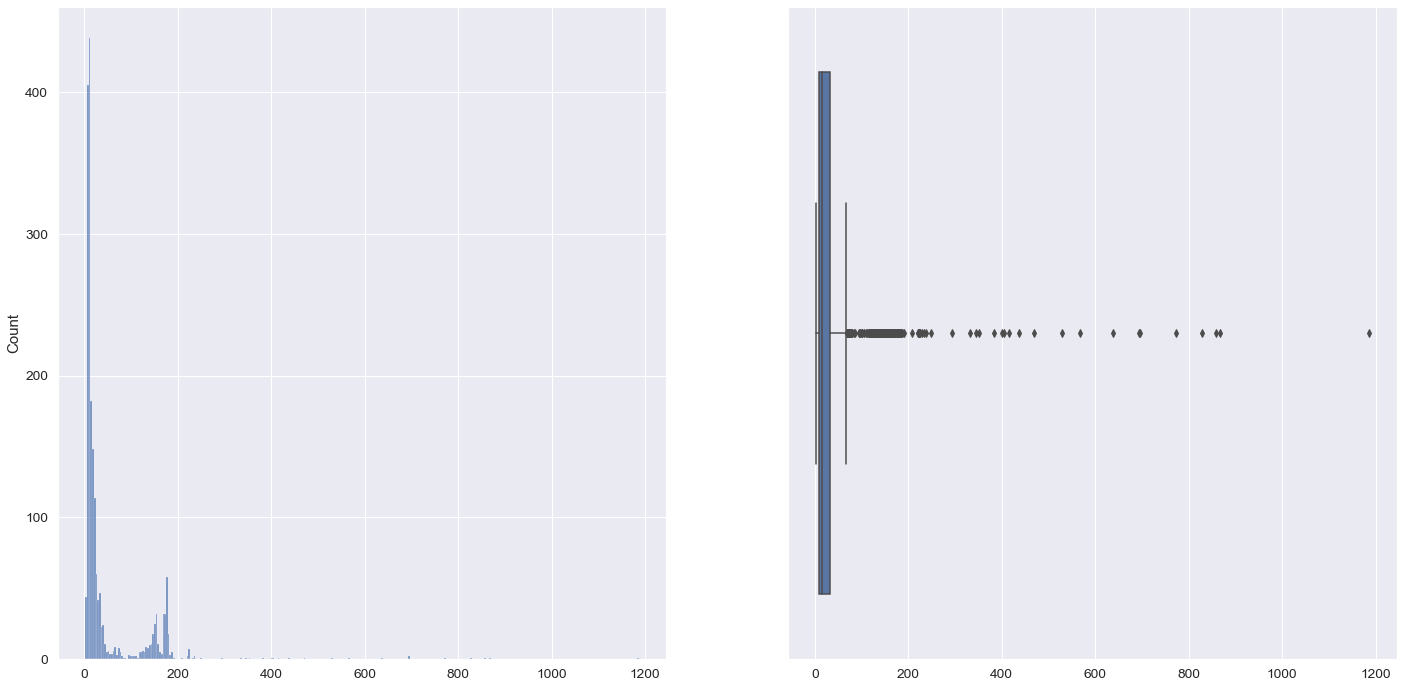

In [110]:
# Не добавляя новый признак, рассмотрим разность между максимальным и минимальным измерением по X
# Из всех значений резко выбивается максимальное значение.
column_insight(steel_features["X_Maximum"]-steel_features["X_Minimum"])

In [111]:
(steel_features["X_Maximum"]-steel_features["X_Minimum"]).quantile(0.99)

275.9999999999959

In [112]:
(steel_features["X_Maximum"]-steel_features["X_Minimum"]).quantile(0.95)

175.0

In [113]:
# 92/1941 имеют экстремально большие значения разности, значительно выбивающиеся из распределения. К сожалению, описание датасета не дает точного определения своим признакам. Можно предположить, что
# минимальные значения близкие или равные 0 означают, что "plate" имеет треугольную форму. Остальные - просто имеют значительные отклонения по оси X.
steel_features[steel_features["X_Maximum"]-steel_features["X_Minimum"]>175][["X_Minimum", "X_Maximum"]]

,X_Minimum,X_Maximum
392,0,230
393,3,223
394,0,225
395,0,436
396,0,224
...,...,...
1382,59,1245
1383,435,729
1390,211,615
1668,772,1006


count     1941.000000
mean       111.855229
std        301.209187
min          2.000000
25%         15.000000
50%         26.000000
75%         84.000000
max      10449.000000
Name: X_Perimeter, dtype: float64
Skewness: 21.53945120177627


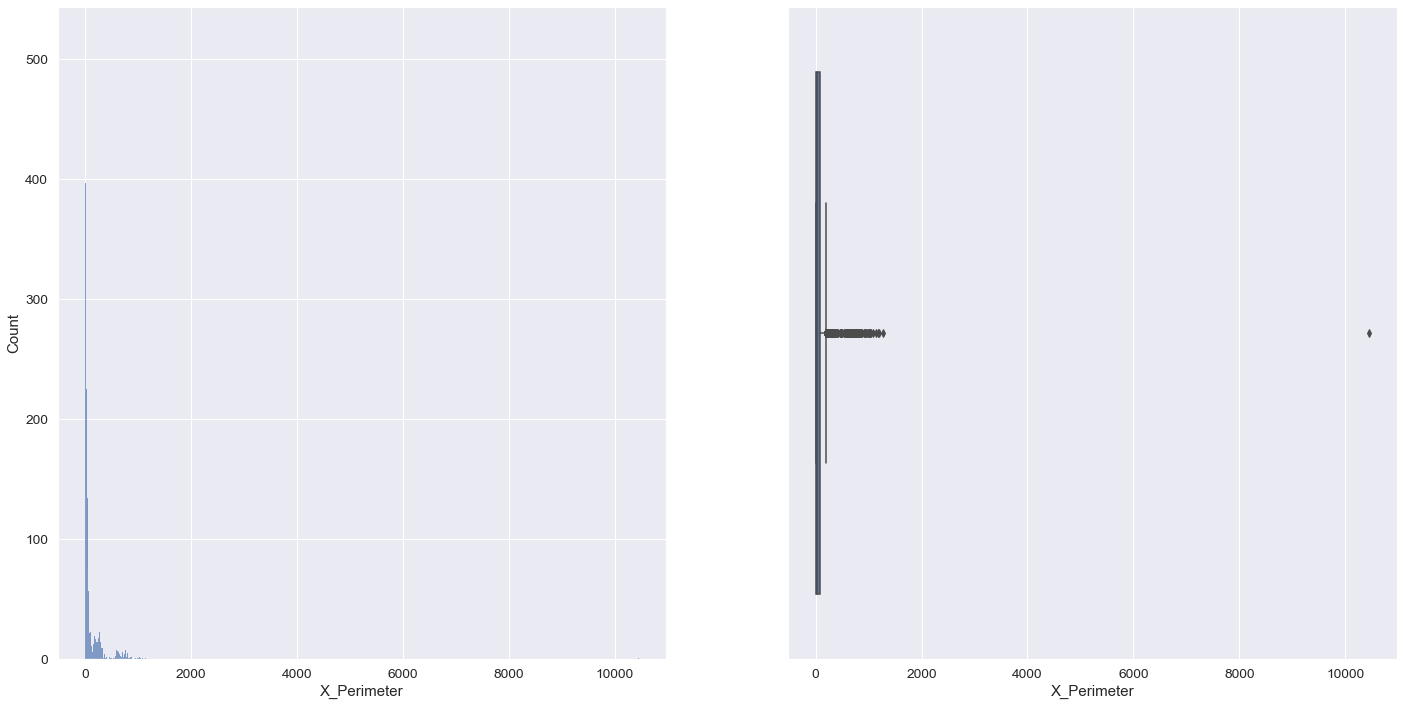

In [114]:
column_insight(steel_features["X_Perimeter"])

In [115]:
# Так же, как и в предыдущем случае, есть ряд значений, значительно выбивающихся из распределения. Особенно выделсяется одно значение, превосходящее 10000ю

In [116]:
steel_features["X_Perimeter"].quantile(0.99)

863.3999999999996

In [117]:
steel_features["X_Perimeter"].quantile(0.95)

616.0

In [118]:
steel_features[steel_features["X_Perimeter"]>616]["X_Perimeter"]

184       748
391     10449
392      1022
393      1138
394       992
        ...  
1152      709
1376      705
1382     1275
1592      908
1668      905
Name: X_Perimeter, Length: 97, dtype: int64

In [119]:
###

count    1.941000e+03
mean     1.650685e+06
std      1.774578e+06
min      6.712000e+03
25%      4.712530e+05
50%      1.204128e+06
75%      2.183073e+06
max      1.298766e+07
Name: Y_Minimum, dtype: float64
Skewness: 2.8112131771546154


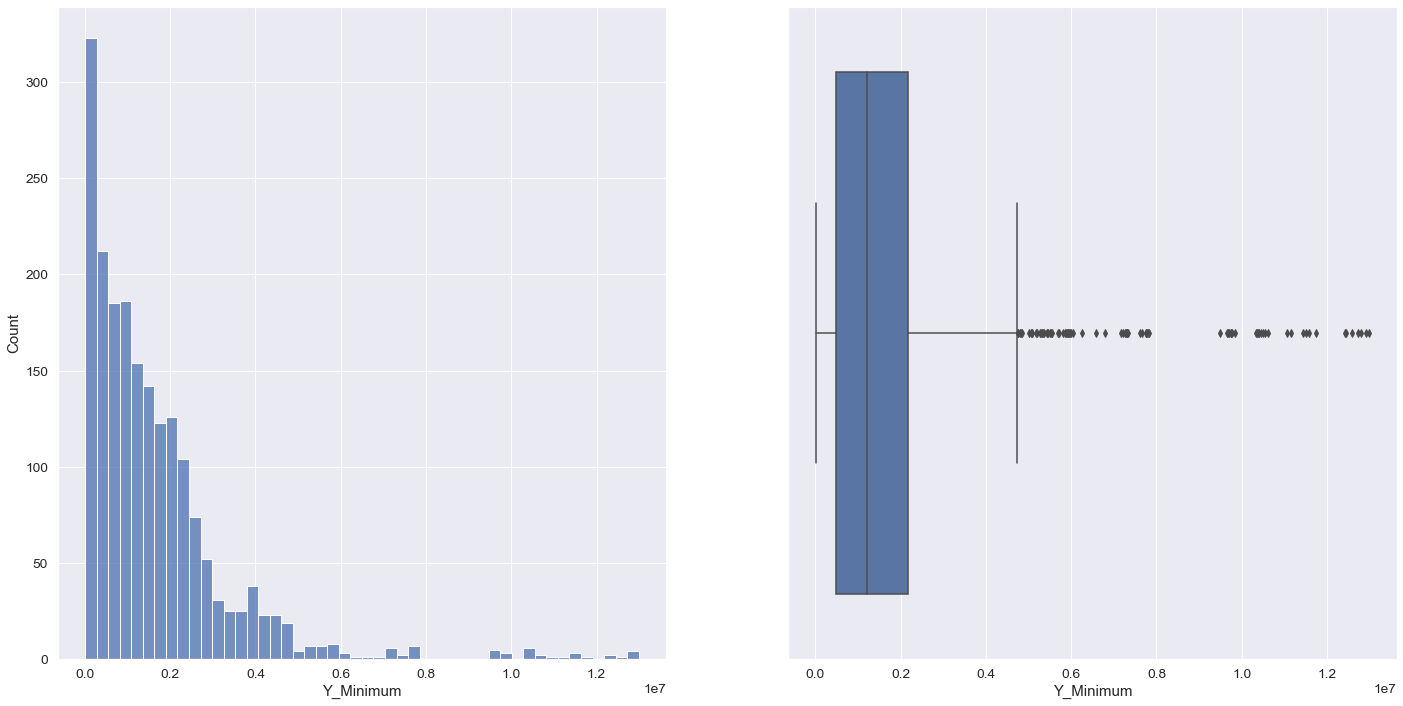

In [120]:
column_insight(steel_features["Y_Minimum"])

In [121]:
# Распределение Y_Minimum несколько отличается от распределения X_Minimum, имеет более пологий хвост справа.

count    1.941000e+03
mean     1.650739e+06
std      1.774590e+06
min      6.724000e+03
25%      4.712810e+05
50%      1.204136e+06
75%      2.183084e+06
max      1.298769e+07
Name: Y_Maximum, dtype: float64
Skewness: 2.8111689562368904


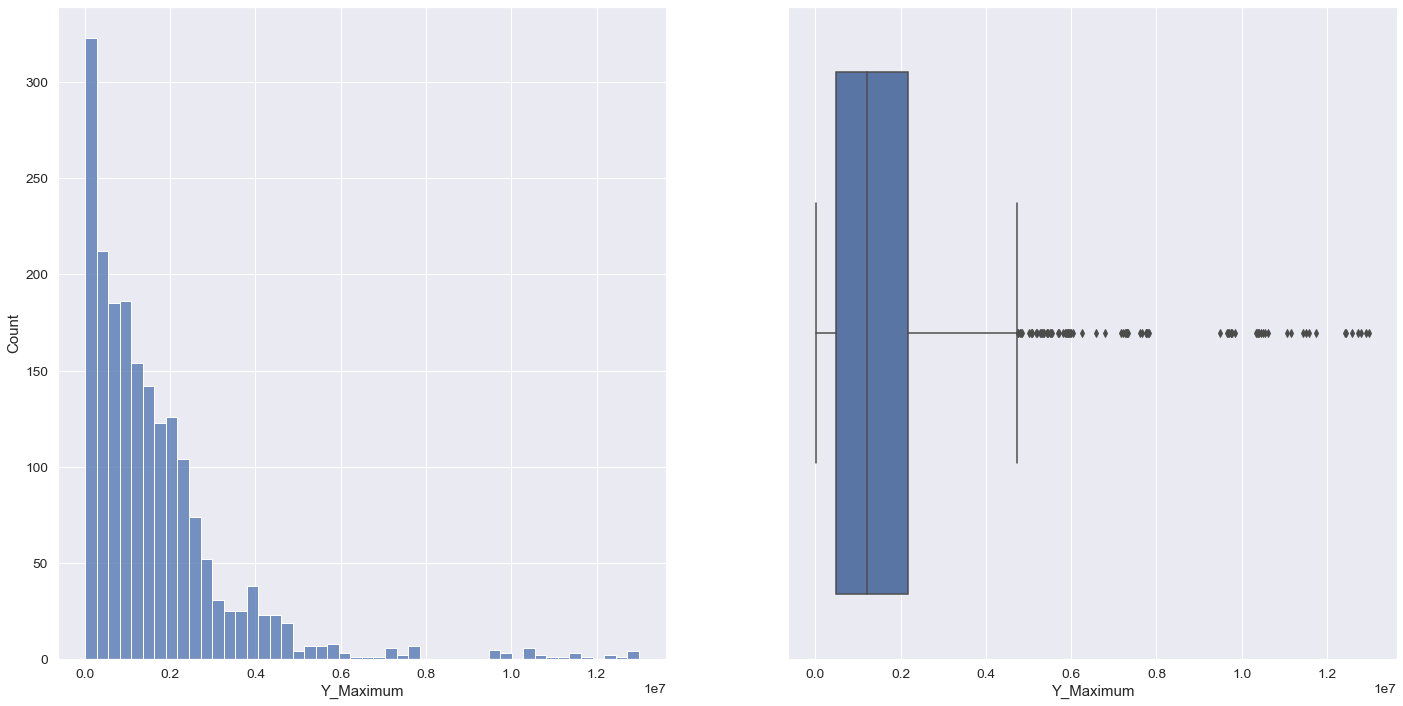

In [122]:
column_insight(steel_features["Y_Maximum"])

In [123]:
# Распределение практически совпадает с "Y_Minimum"

count     1941.000000
mean        53.837197
std        414.745555
min          1.000000
25%         12.000000
50%         21.000000
75%         54.000000
max      18141.000000
dtype: float64
Skewness: 42.803316392823604


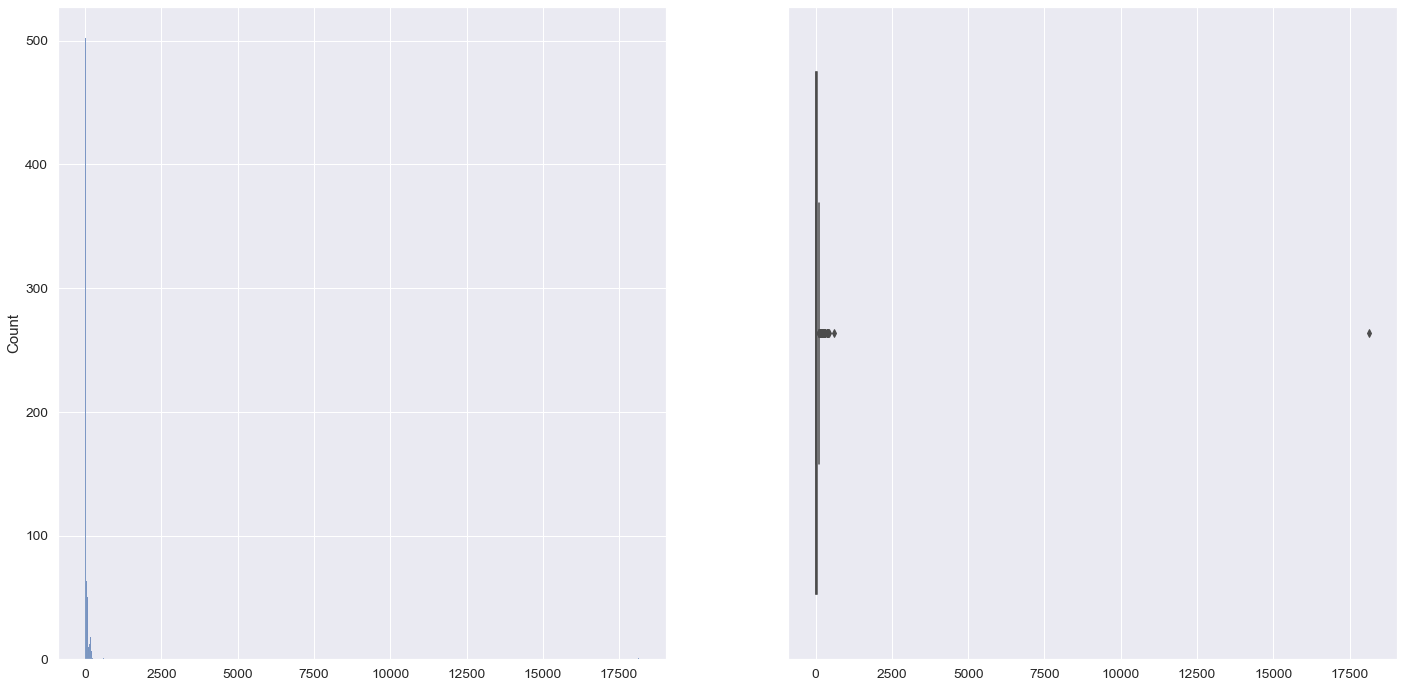

In [124]:
column_insight(steel_features["Y_Maximum"]-steel_features["Y_Minimum"])

In [125]:
(steel_features["Y_Maximum"]-steel_features["Y_Minimum"]).quantile(0.99)

279.1999999999998

In [126]:
(steel_features["Y_Maximum"]-steel_features["Y_Minimum"]).quantile(0.95)

170.0

In [127]:
steel_features[steel_features["Y_Maximum"]-steel_features["Y_Minimum"]>170]

,Edges_Index,Edges_X_Index,Edges_Y_Index,Empty_Index,Length_of_Conveyer,LogOfAreas,Log_X_Index,Log_Y_Index,Luminosity_Index,Maximum_of_Luminosity,...,Steel_Plate_Thickness,Sum_of_Luminosity,TypeOfSteel_A300,TypeOfSteel_A400,X_Maximum,X_Minimum,X_Perimeter,Y_Maximum,Y_Minimum,Y_Perimeter
4,0.0695,0.2833,0.9885,0.4486,1353,3.3818,1.2305,2.4099,-0.1992,126,...,185,246930,0,1,1306,1289,60,498335,498078,260
6,0.4896,0.1435,0.9607,0.3390,1687,3.9567,1.5185,2.6181,0.2791,199,...,150,1481991,0,1,446,413,230,138883,138468,432
16,0.1849,0.2156,0.9503,0.4772,1687,3.7028,1.5563,2.4281,-0.1157,143,...,150,570911,0,1,192,156,167,714056,713788,282
28,0.1034,0.2283,0.9921,0.3902,1373,3.5071,1.3222,2.3997,-0.1045,140,...,40,368381,0,1,1302,1281,92,4332815,4332564,253
78,0.1771,0.0970,0.9860,0.4121,1400,3.4221,1.2041,2.4487,-0.1132,140,...,40,300024,0,1,140,124,165,2377320,2377039,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707,0.2080,0.1215,0.9273,0.6241,1394,3.2997,1.4150,2.3096,-0.0753,135,...,220,236010,0,1,171,145,214,233671,233467,220
1708,0.1621,0.1144,0.6852,0.5757,1394,3.5181,1.6233,2.2672,-0.0184,143,...,220,414252,0,1,155,113,367,264160,263975,270
1709,0.1621,0.1096,0.6567,0.6760,1394,3.3581,1.6021,2.2455,-0.0161,143,...,220,287273,0,1,153,113,365,310797,310621,268
1748,0.4686,0.2687,0.9000,0.6823,1387,3.3137,1.5563,2.2553,0.4195,199,...,40,374117,0,1,361,325,134,58747,58567,200


count     1941.000000
mean        82.965997
std        426.482879
min          1.000000
25%         13.000000
50%         25.000000
75%         83.000000
max      18152.000000
Name: Y_Perimeter, dtype: float64
Skewness: 39.29315840666641


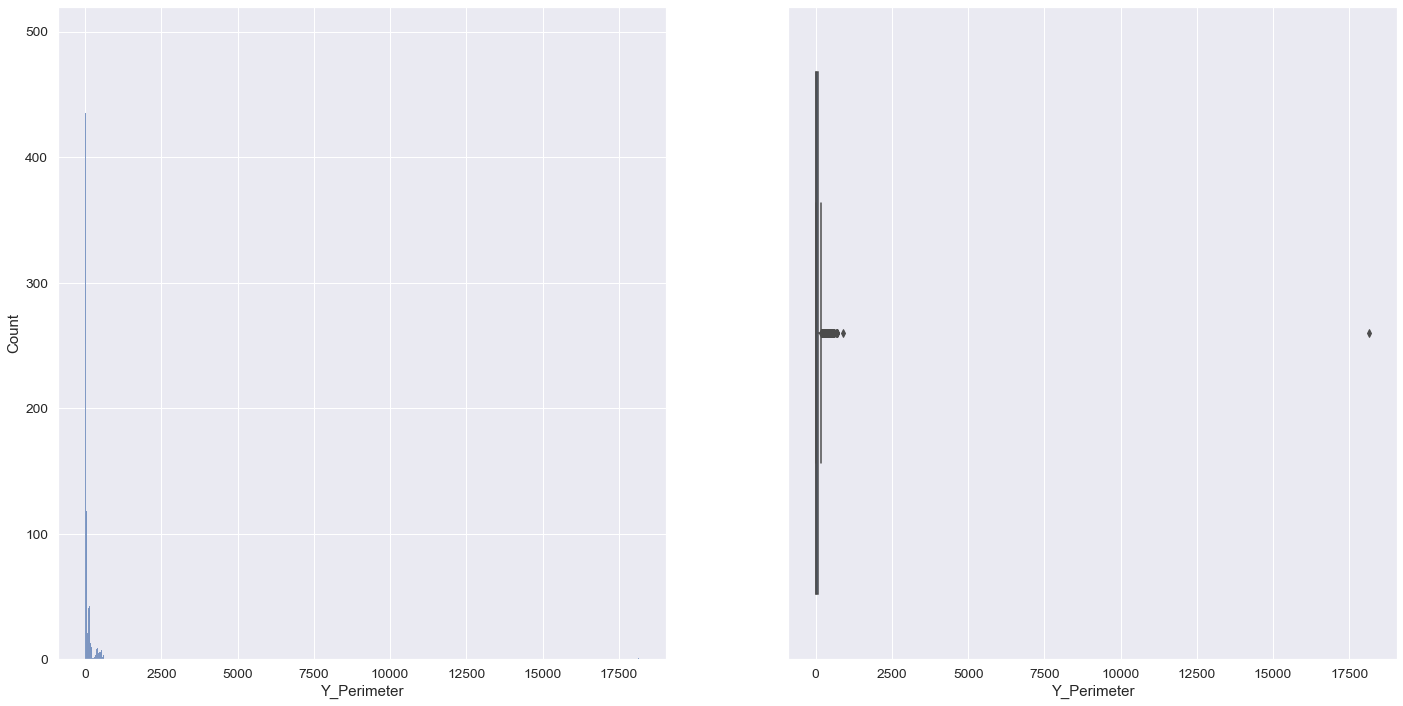

In [128]:
column_insight(steel_features["Y_Perimeter"])

In [129]:
steel_features["Y_Perimeter"].quantile(0.99)

539.0

In [130]:
steel_features["Y_Perimeter"].quantile(0.95)

381.0

In [131]:
steel_features[steel_features["Y_Perimeter"]>381]["Y_Perimeter"]

6       432
83      604
135     427
184     403
209     536
       ... 
1152    425
1289    392
1529    395
1592    903
1668    583
Name: Y_Perimeter, Length: 97, dtype: int64

In [132]:
# Судя по графикам boxplot разностей и периметров можно предположить, что признак периметр содержит в себе информацию (или часть информации) о разности max-min.

In [133]:
###

count      1941.000000
mean       1893.878413
std        5168.459560
min           2.000000
25%          84.000000
50%         174.000000
75%         822.000000
max      152655.000000
Name: Pixels_Areas, dtype: float64
Skewness: 14.083822279294504


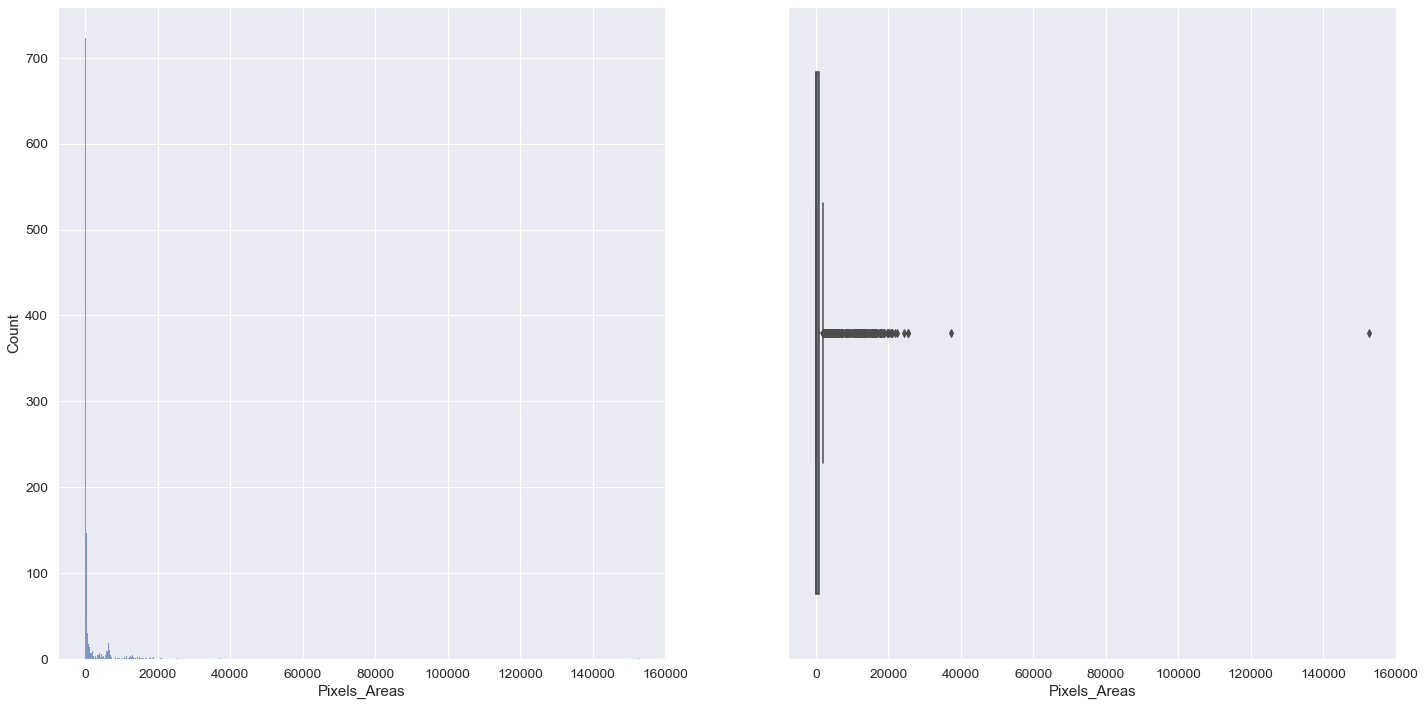

In [134]:
column_insight(steel_features["Pixels_Areas"])

In [135]:
steel_features["Pixels_Areas"].quantile(0.99)

18033.39999999999

In [136]:
steel_features["Pixels_Areas"].quantile(0.95)

11211.0

In [137]:
###

count    1.941000e+03
mean     2.063121e+05
std      5.122936e+05
min      2.500000e+02
25%      9.522000e+03
50%      1.920200e+04
75%      8.301100e+04
max      1.159141e+07
Name: Sum_of_Luminosity, dtype: float64
Skewness: 7.730719967094412


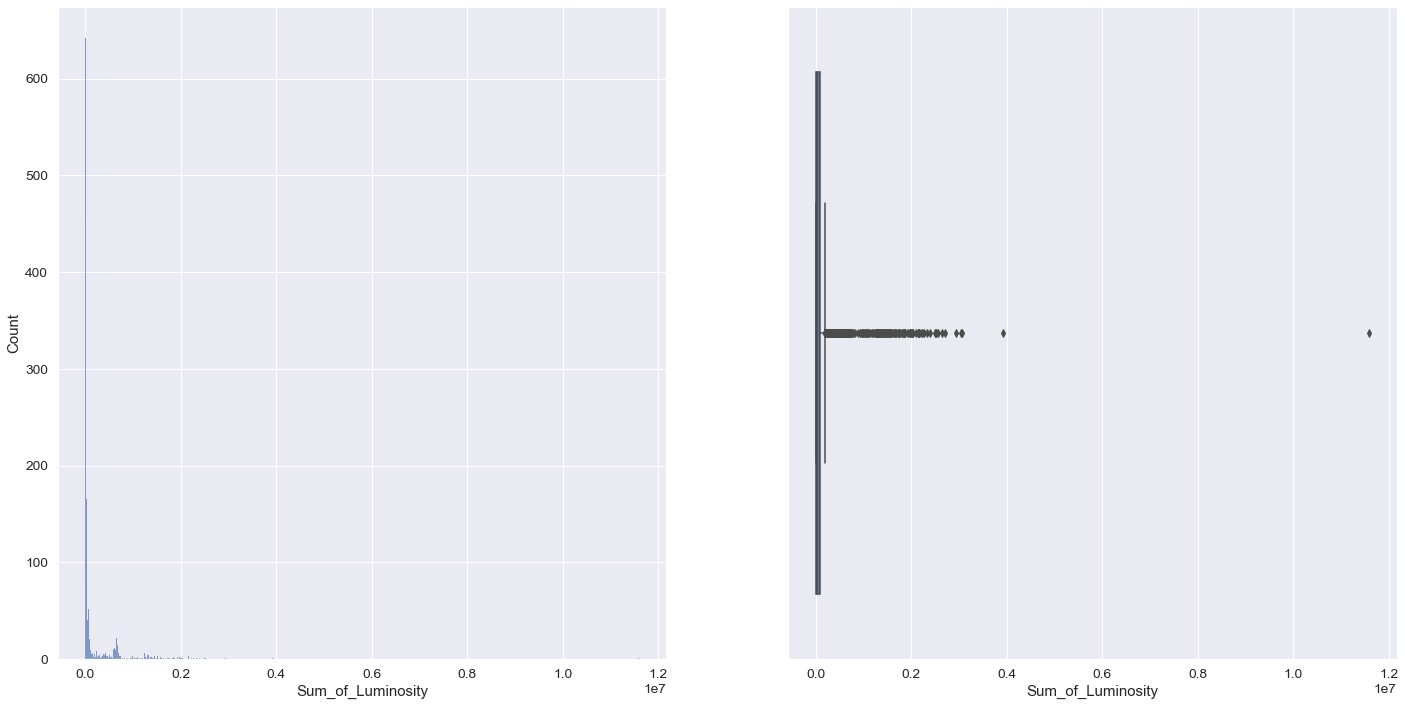

In [138]:
column_insight(steel_features["Sum_of_Luminosity"])

In [139]:
steel_features["Sum_of_Luminosity"].quantile(0.99)

2155800.8

In [140]:
steel_features["Sum_of_Luminosity"].quantile(0.95)

1293558.0

In [141]:
###

count    1941.000000
mean       84.548686
std        32.134276
min         0.000000
25%        63.000000
50%        90.000000
75%       106.000000
max       203.000000
Name: Minimum_of_Luminosity, dtype: float64
Skewness: -0.10709775866081438


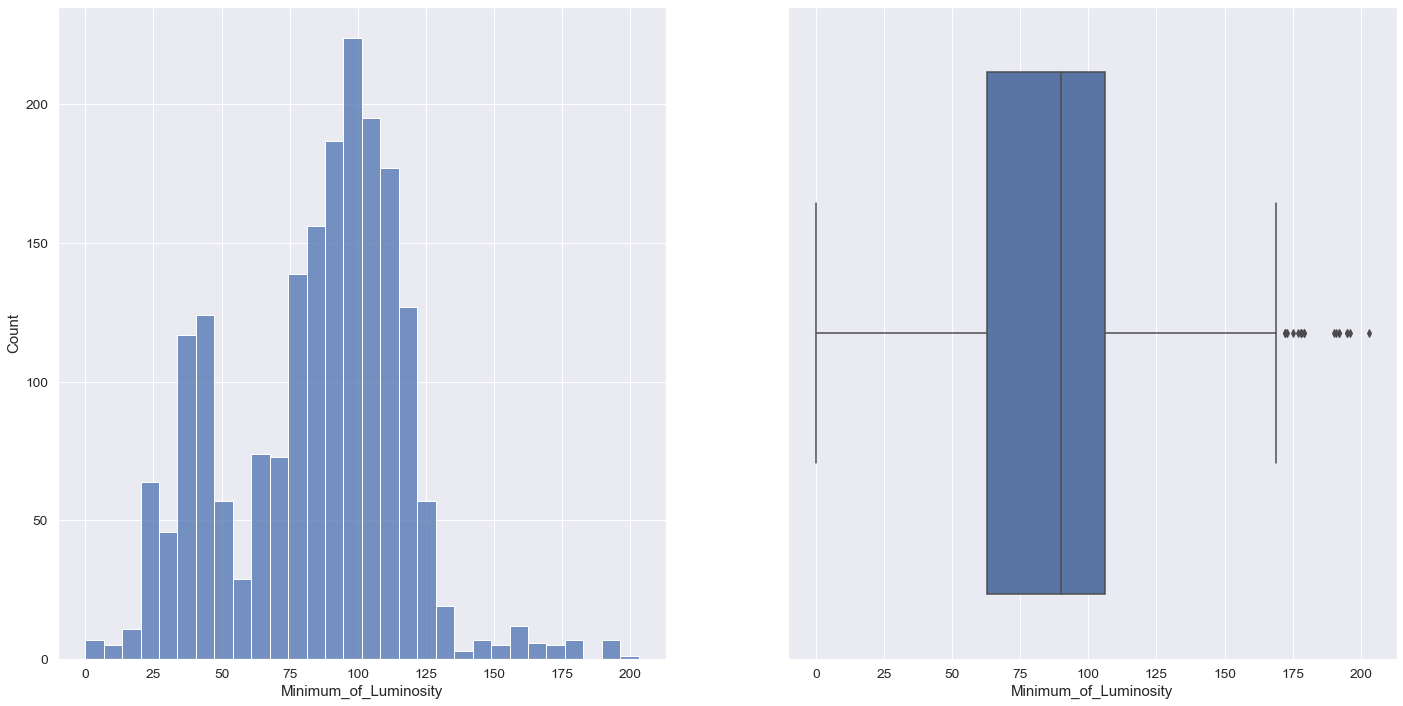

In [142]:
column_insight(steel_features["Minimum_of_Luminosity"])

count    1941.000000
mean      130.193715
std        18.690992
min        37.000000
25%       124.000000
50%       127.000000
75%       140.000000
max       253.000000
Name: Maximum_of_Luminosity, dtype: float64
Skewness: 1.2870353871459246


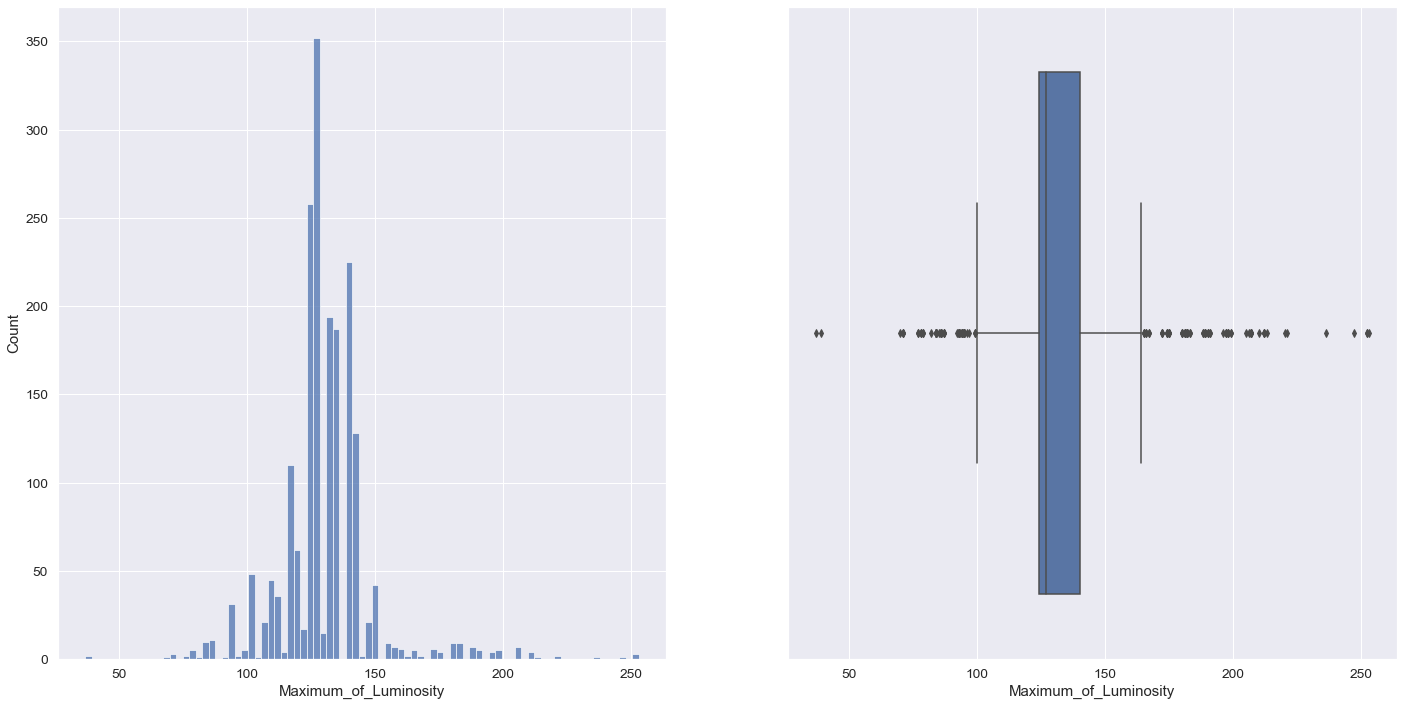

In [143]:
column_insight(steel_features["Maximum_of_Luminosity"])

count    1941.000000
mean     1459.160227
std       144.577823
min      1227.000000
25%      1358.000000
50%      1364.000000
75%      1650.000000
max      1794.000000
Name: Length_of_Conveyer, dtype: float64
Skewness: 0.8514222506284674


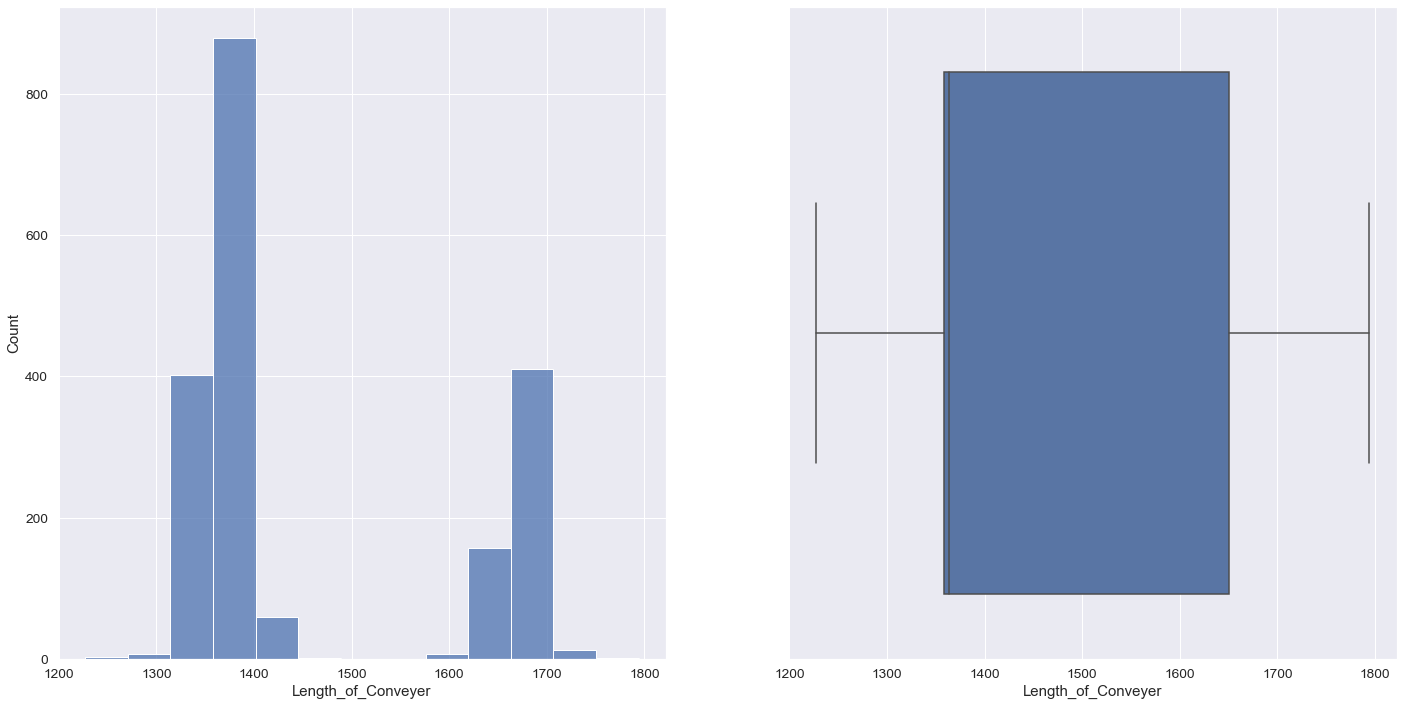

In [144]:
column_insight(steel_features["Length_of_Conveyer"])

In [145]:
steel_features["Length_of_Conveyer"].unique()

array([1687, 1623, 1353, 1387, 1373, 1627, 1333, 1633, 1690, 1686, 1682,
       1688, 1650, 1648, 1646, 1710, 1360, 1362, 1632, 1630, 1654, 1656,
       1658, 1694, 1692, 1352, 1400, 1380, 1666, 1364, 1392, 1366, 1358,
       1626, 1634, 1350, 1354, 1698, 1696, 1700, 1356, 1708, 1348, 1336,
       1402, 1404, 1398, 1396, 1378, 1664, 1670, 1652, 1707, 1467, 1227,
       1684, 1376, 1368, 1660, 1662, 1628, 1624, 1622, 1668, 1374, 1306,
       1308, 1794, 1322, 1320, 1324, 1370, 1372, 1618, 1394, 1715, 1346,
       1280, 1712, 1620, 1614, 1602, 1604, 1600], dtype=int64)

In [146]:
steel_features["TypeOfSteel_A300"].value_counts()

0    1164
1     777
Name: TypeOfSteel_A300, dtype: int64

In [147]:
steel_features["TypeOfSteel_A400"].value_counts()

1    1164
0     777
Name: TypeOfSteel_A400, dtype: int64

count    1941.000000
mean       78.737764
std        55.086032
min        40.000000
25%        40.000000
50%        70.000000
75%        80.000000
max       300.000000
Name: Steel_Plate_Thickness, dtype: float64
Skewness: 2.2069350885703467


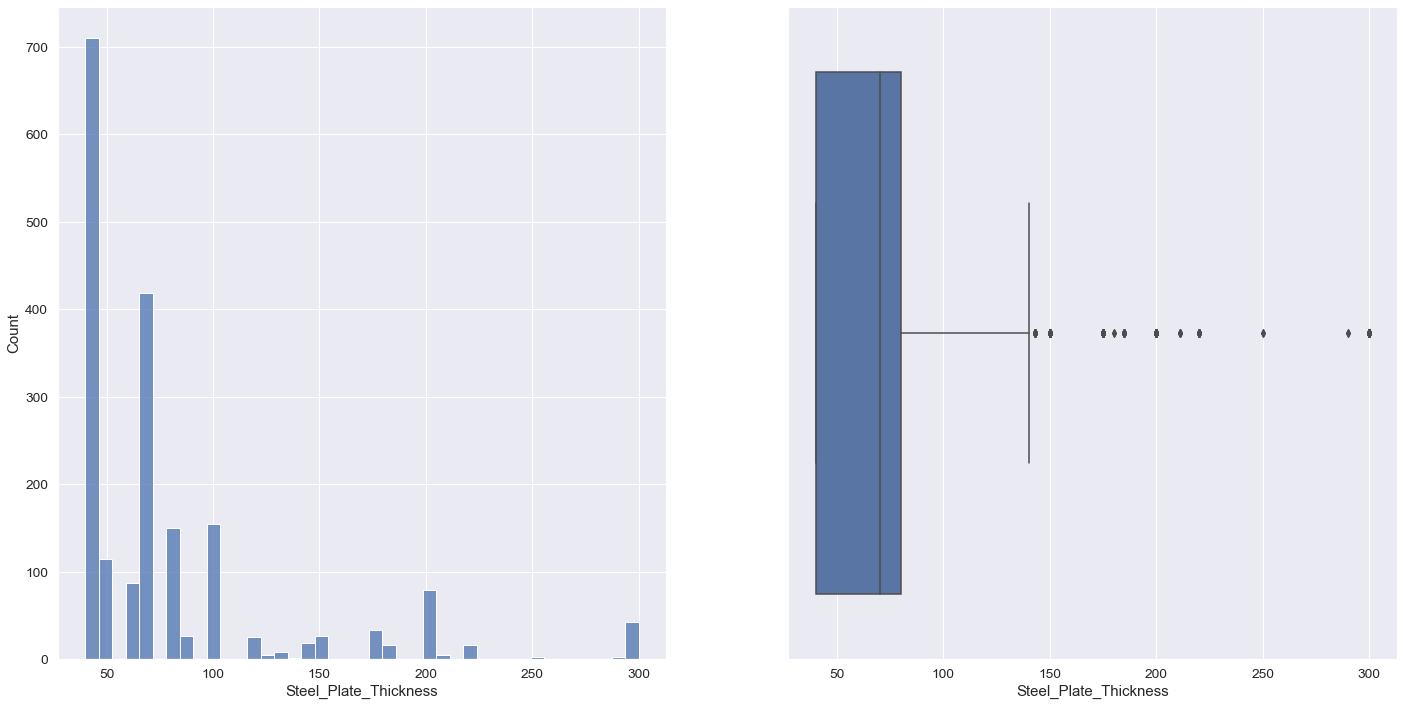

In [148]:
column_insight(steel_features["Steel_Plate_Thickness"])

count    1941.000000
mean        0.331715
std         0.299712
min         0.000000
25%         0.060400
50%         0.227300
75%         0.573800
max         0.995200
Name: Edges_Index, dtype: float64
Skewness: 0.68577108030141


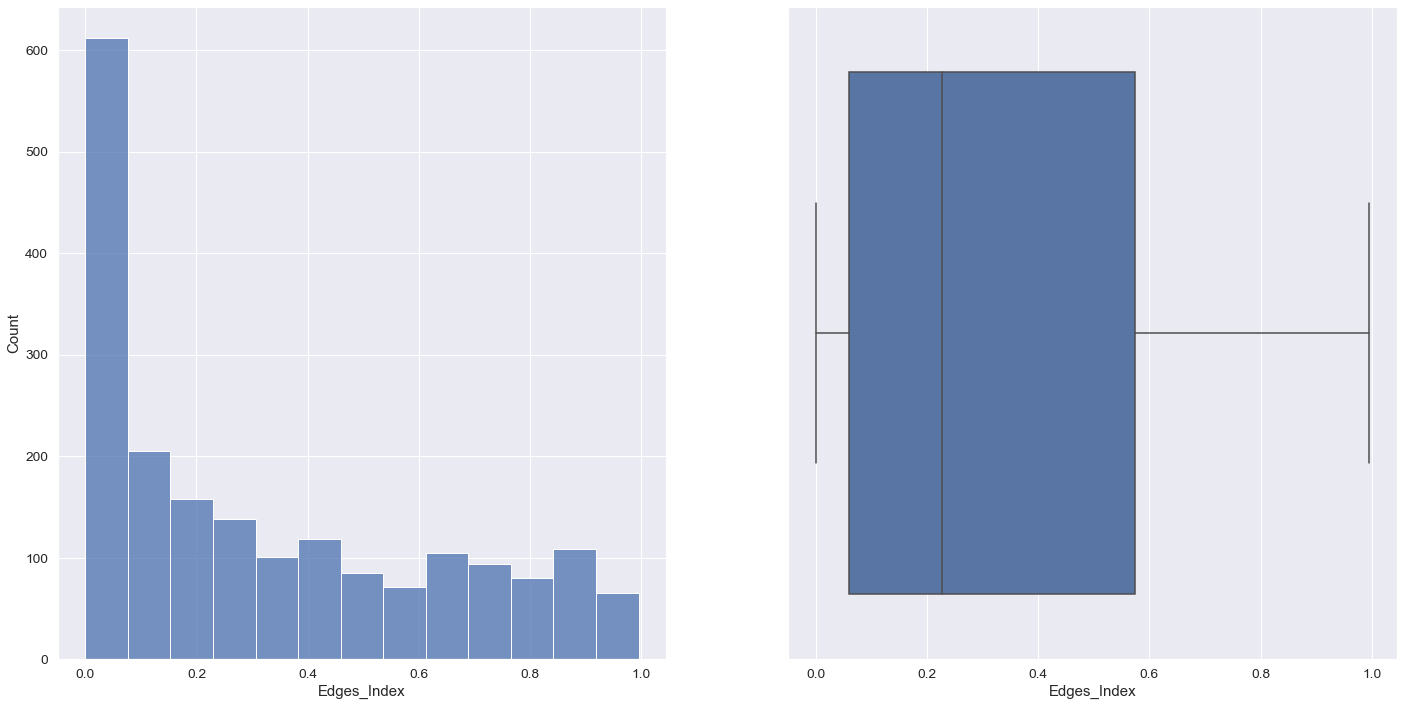

In [149]:
column_insight(steel_features["Edges_Index"])

count    1941.000000
mean        0.414203
std         0.137261
min         0.000000
25%         0.315800
50%         0.412100
75%         0.501600
max         0.943900
Name: Empty_Index, dtype: float64
Skewness: 0.2934677600757725


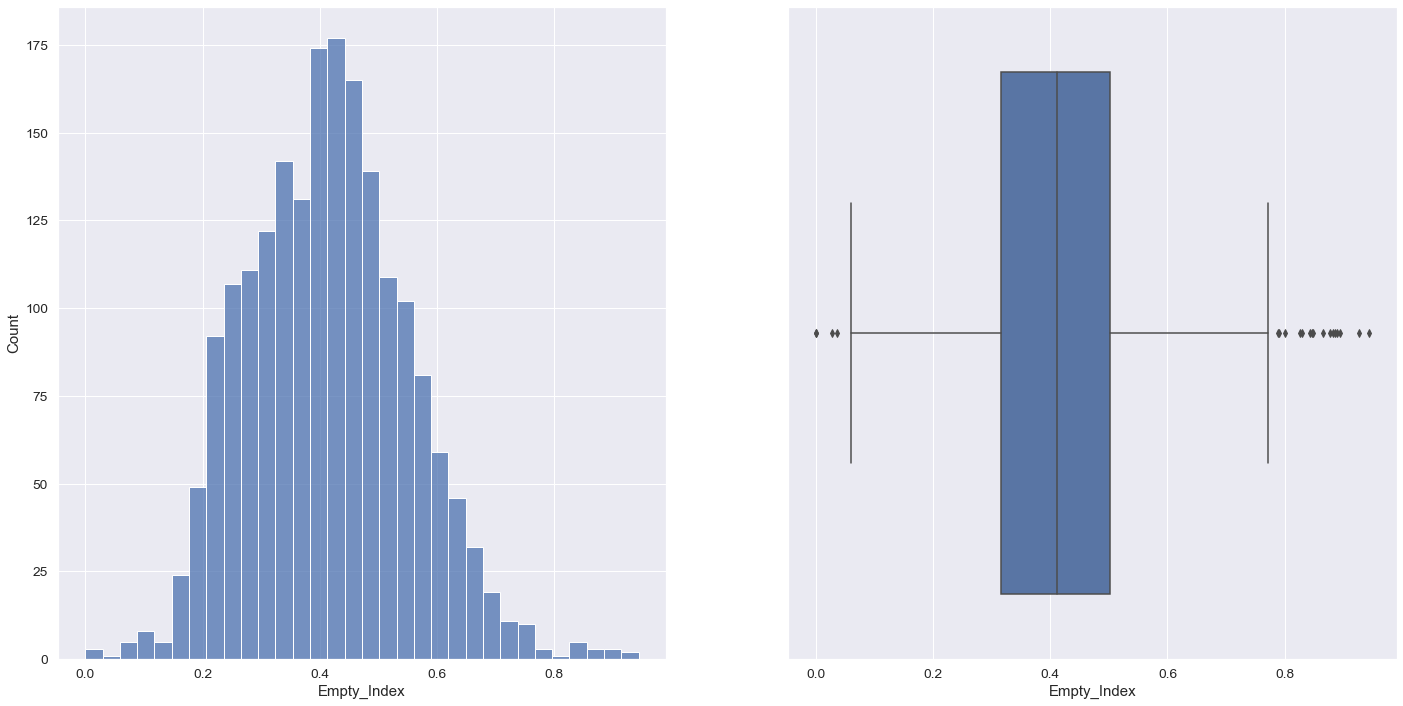

In [150]:
column_insight(steel_features["Empty_Index"])

count    1941.000000
mean        0.570767
std         0.271058
min         0.008300
25%         0.361300
50%         0.555600
75%         0.818200
max         1.000000
Name: Square_Index, dtype: float64
Skewness: -0.056305677082068996


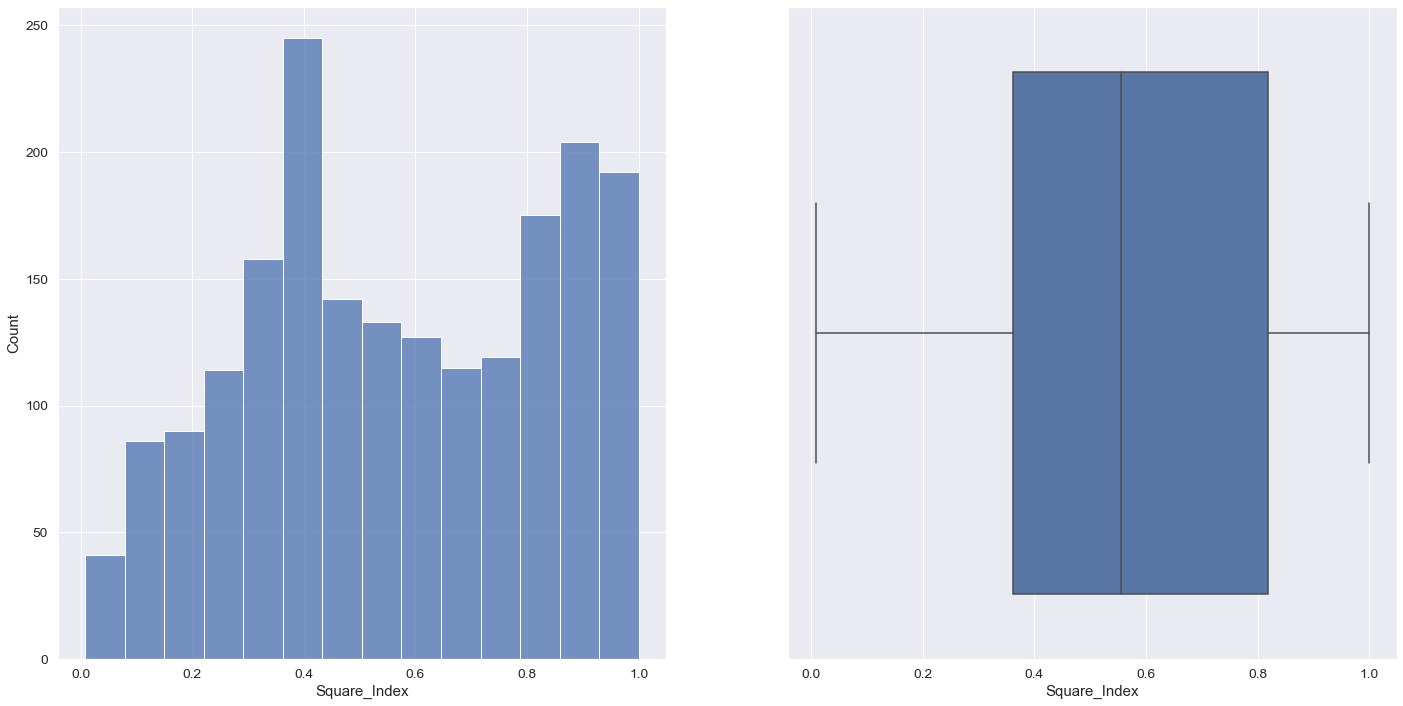

In [151]:
column_insight(steel_features["Square_Index"])

count    1941.000000
mean        0.033361
std         0.058961
min         0.001500
25%         0.006600
50%         0.010100
75%         0.023500
max         0.875900
Name: Outside_X_Index, dtype: float64
Skewness: 5.181830140284012


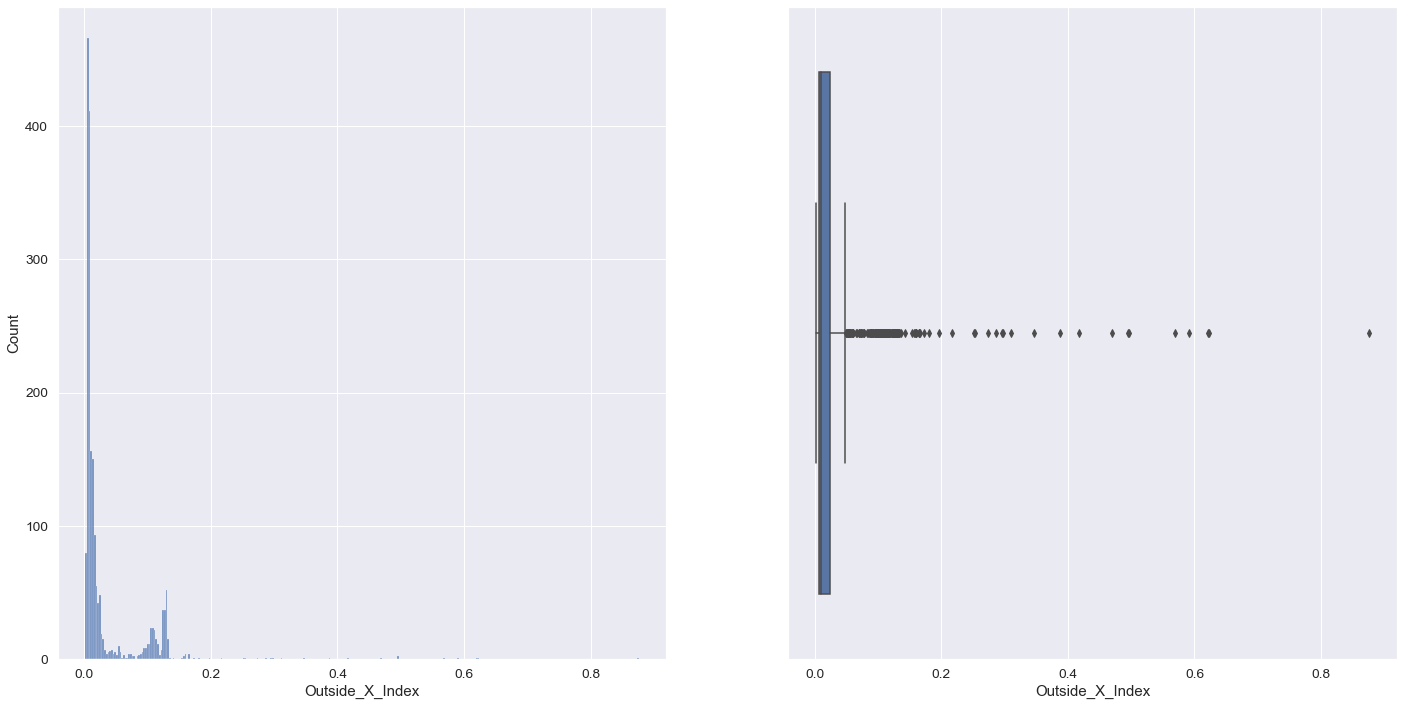

In [152]:
column_insight(steel_features["Outside_X_Index"])

count    1941.000000
mean        0.610529
std         0.243277
min         0.014400
25%         0.411800
50%         0.636400
75%         0.800000
max         1.000000
Name: Edges_X_Index, dtype: float64
Skewness: -0.2350958701679194


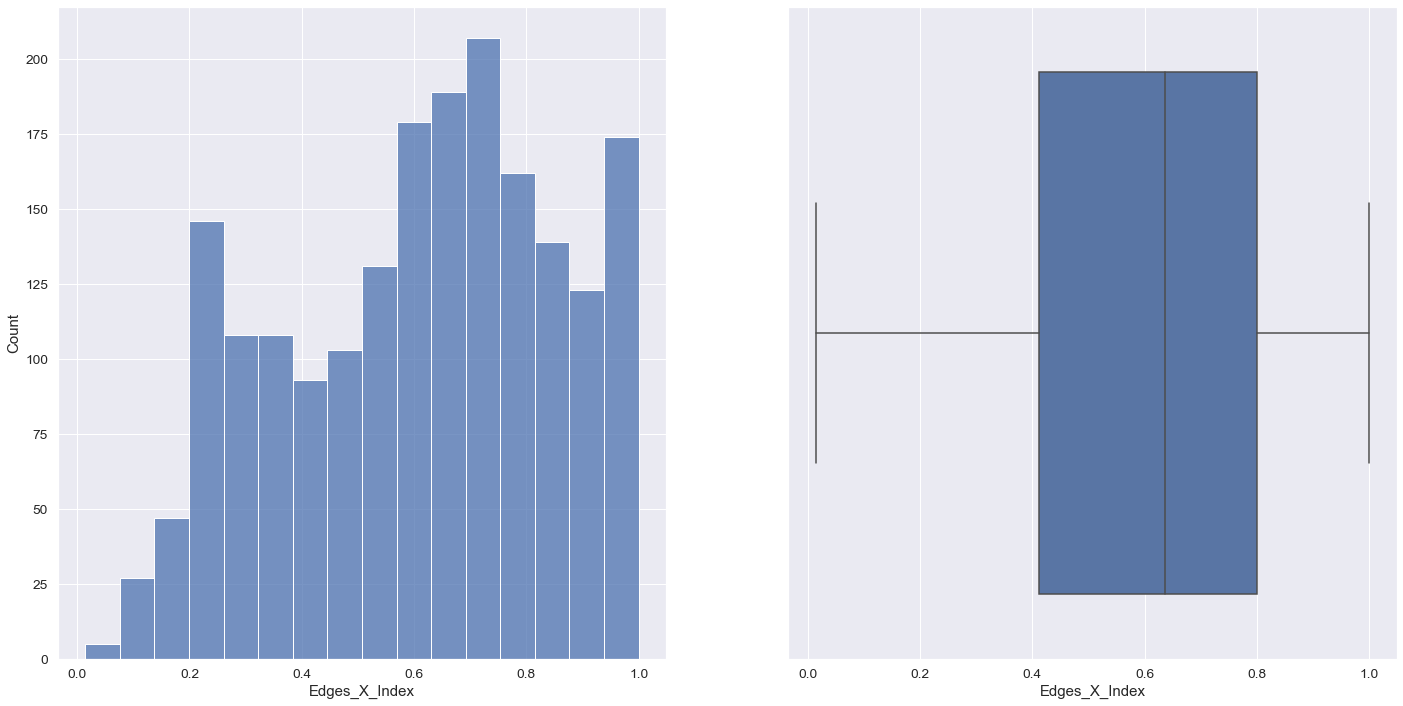

In [153]:
column_insight(steel_features["Edges_X_Index"])

count    1941.000000
mean        0.813472
std         0.234274
min         0.048400
25%         0.596800
50%         0.947400
75%         1.000000
max         1.000000
Name: Edges_Y_Index, dtype: float64
Skewness: -0.9285824124769959


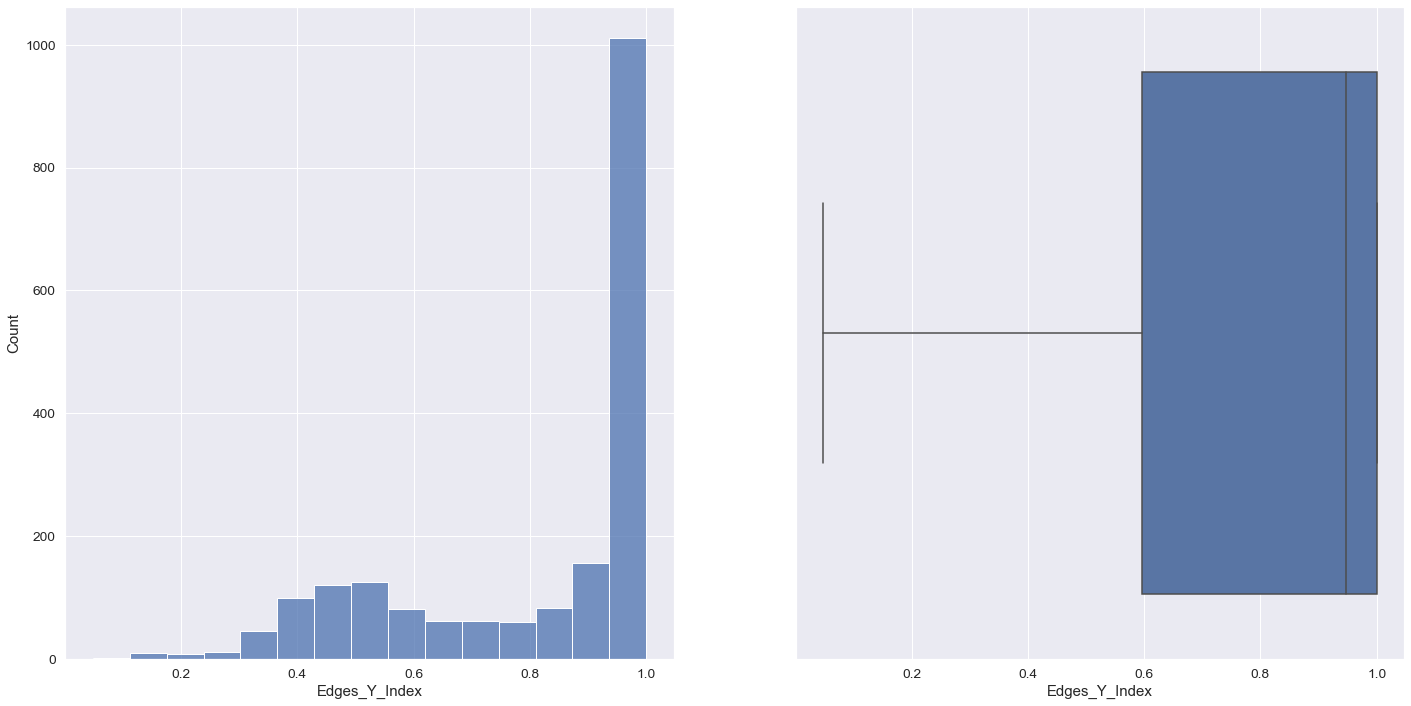

In [154]:
column_insight(steel_features["Edges_Y_Index"])

In [155]:
steel_features["Outside_Global_Index"].value_counts()

1.0    1072
0.0     778
0.5      91
Name: Outside_Global_Index, dtype: int64

count    1941.000000
mean        2.492388
std         0.788930
min         0.301000
25%         1.924300
50%         2.240600
75%         2.914900
max         5.183700
Name: LogOfAreas, dtype: float64
Skewness: 0.7482844785675417


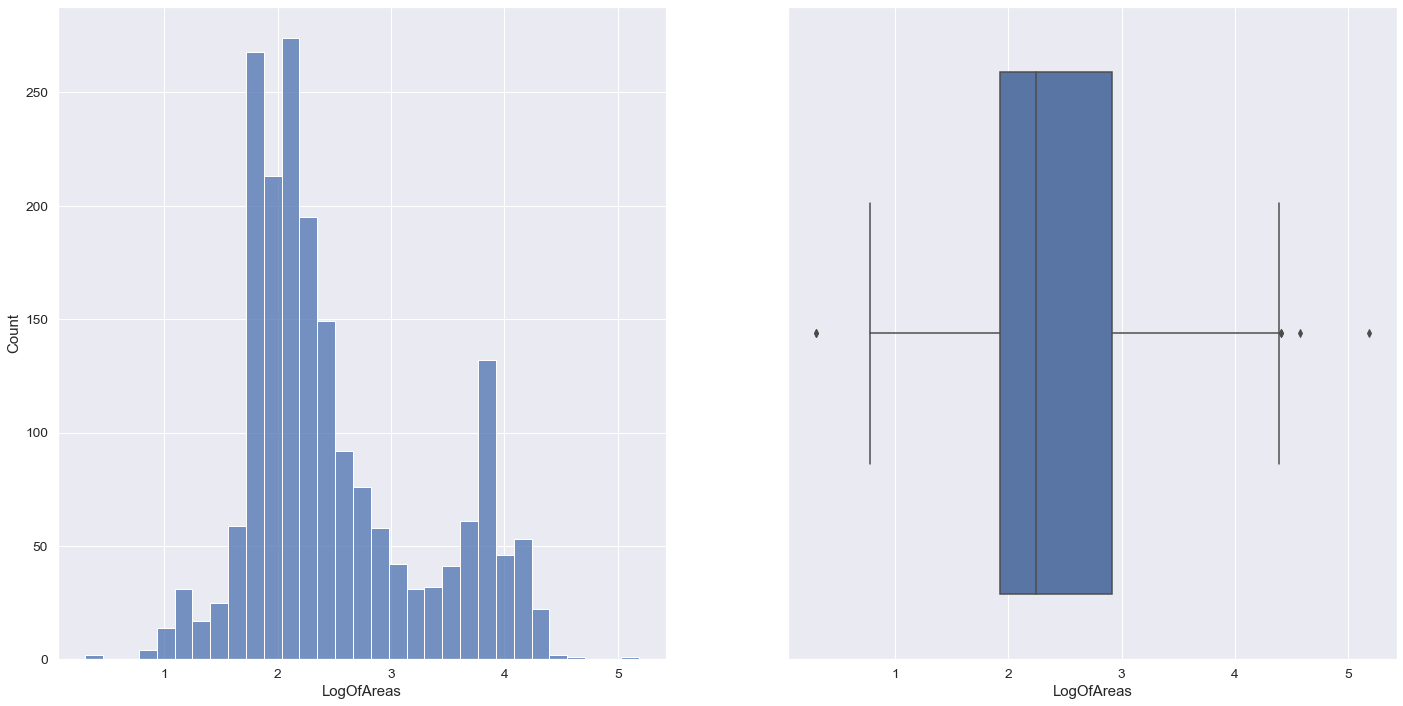

In [156]:
column_insight(steel_features["LogOfAreas"])

count    1941.000000
mean        1.335686
std         0.481612
min         0.301000
25%         1.000000
50%         1.176100
75%         1.518500
max         3.074100
Name: Log_X_Index, dtype: float64
Skewness: 1.0010140538171912


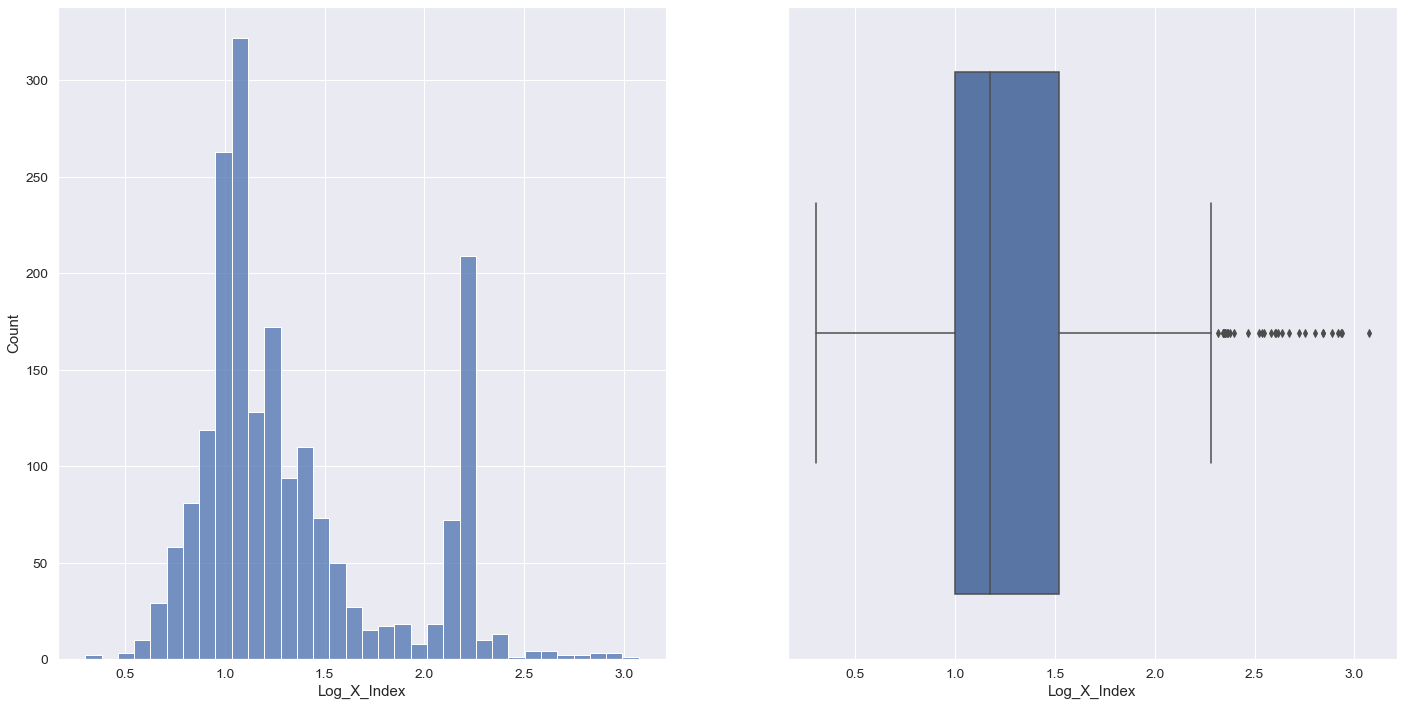

In [157]:
column_insight(steel_features["Log_X_Index"])

count    1941.000000
mean        1.403271
std         0.454345
min         0.000000
25%         1.079200
50%         1.322200
75%         1.732400
max         4.258700
Name: Log_Y_Index, dtype: float64
Skewness: 0.44510060642045945


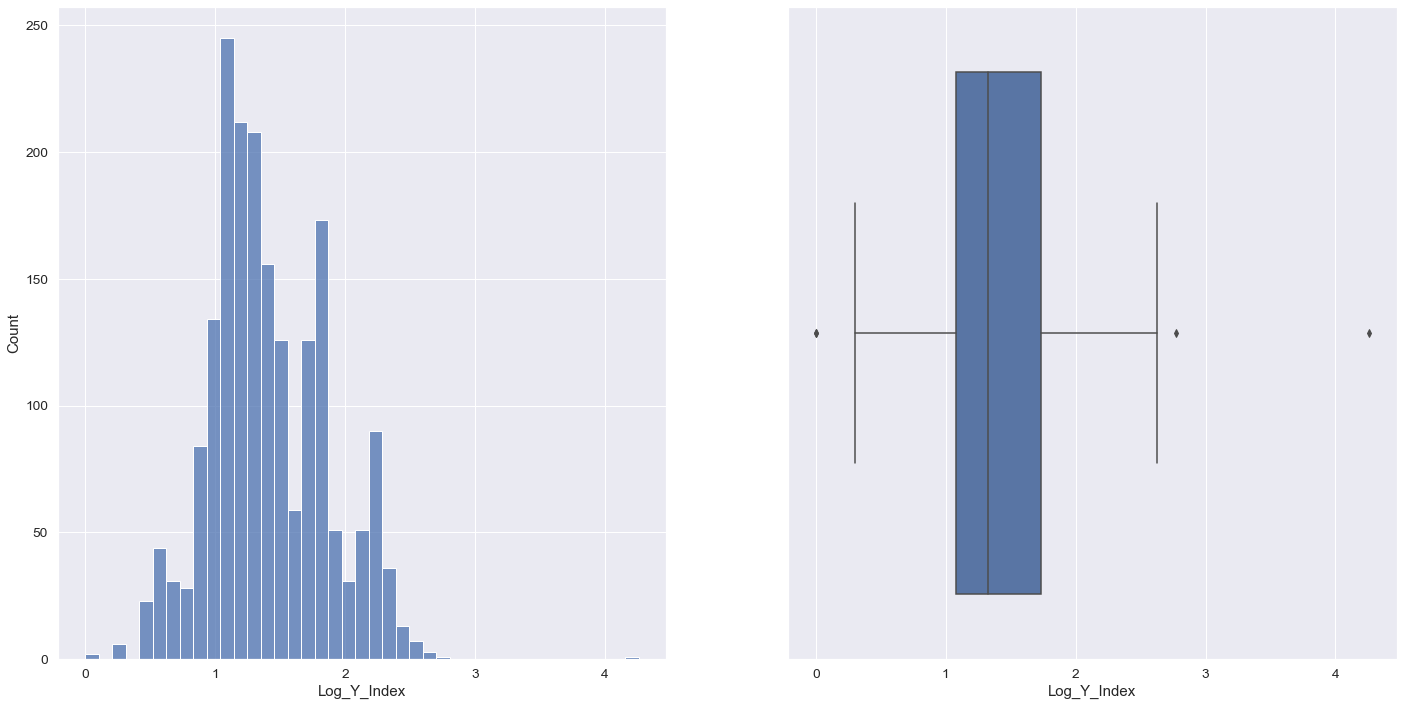

In [158]:
column_insight(steel_features["Log_Y_Index"])

count    1941.000000
mean        0.083288
std         0.500868
min        -0.991000
25%        -0.333300
50%         0.095200
75%         0.511600
max         0.991700
Name: Orientation_Index, dtype: float64
Skewness: -0.15344552173876208


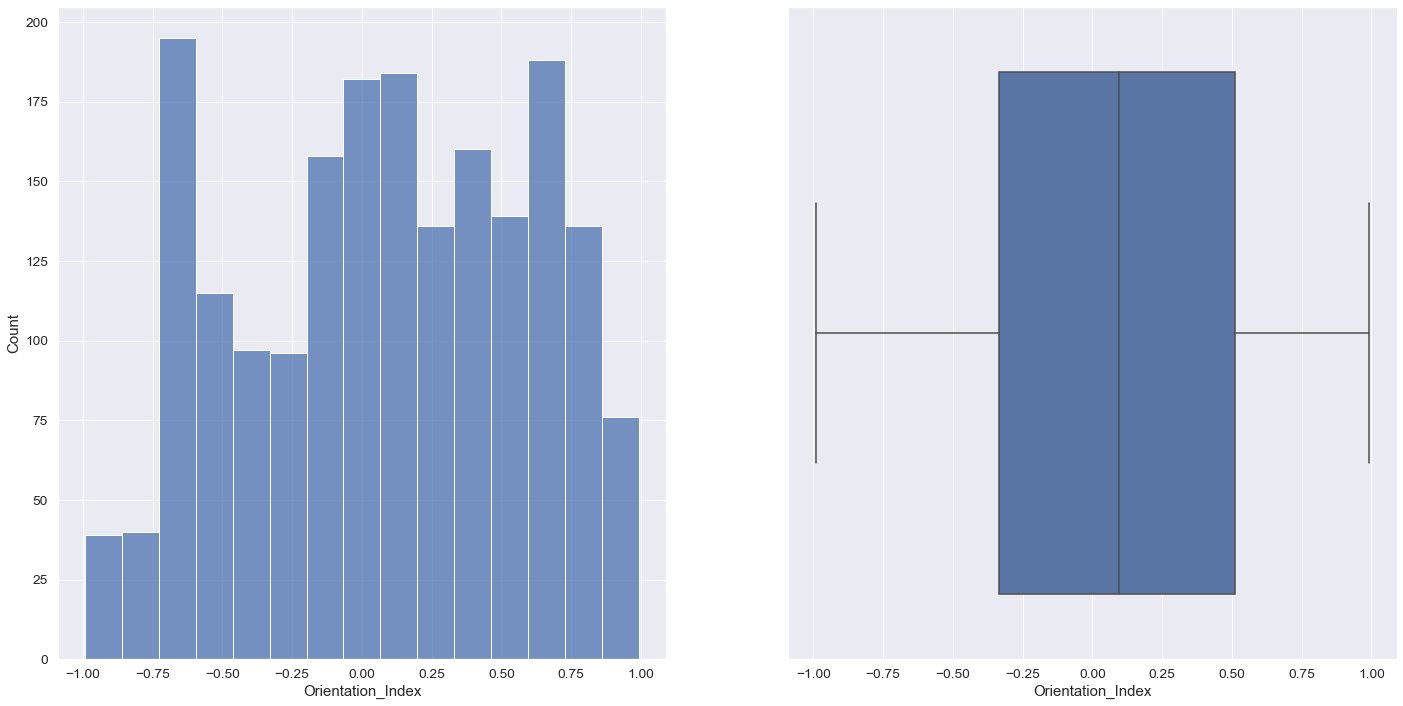

In [159]:
column_insight(steel_features["Orientation_Index"])

count    1941.000000
mean       -0.131305
std         0.148767
min        -0.998900
25%        -0.195000
50%        -0.133000
75%        -0.066600
max         0.642100
Name: Luminosity_Index, dtype: float64
Skewness: 0.6793387184952059


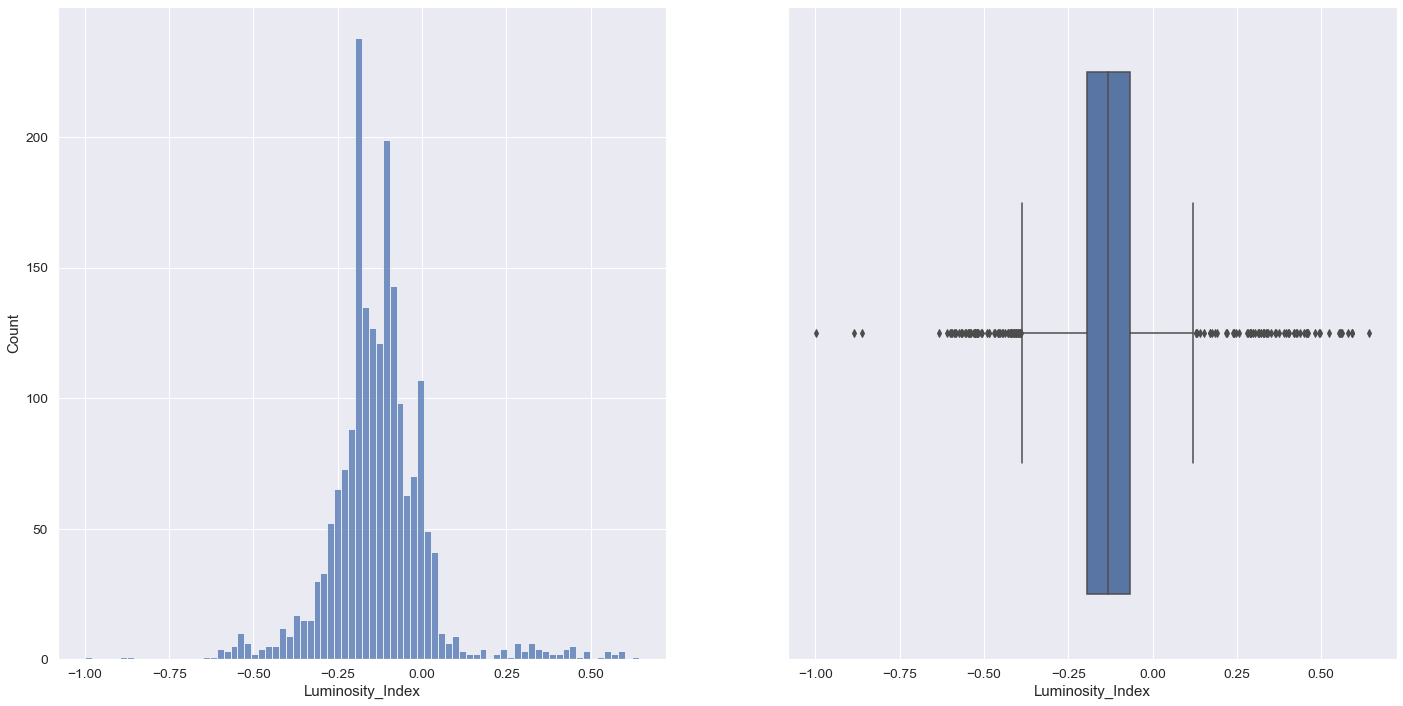

In [160]:
column_insight(steel_features["Luminosity_Index"])

count    1941.000000
mean        0.585420
std         0.339452
min         0.119000
25%         0.248200
50%         0.506300
75%         0.999800
max         1.000000
Name: SigmoidOfAreas, dtype: float64
Skewness: 0.12578852031296278


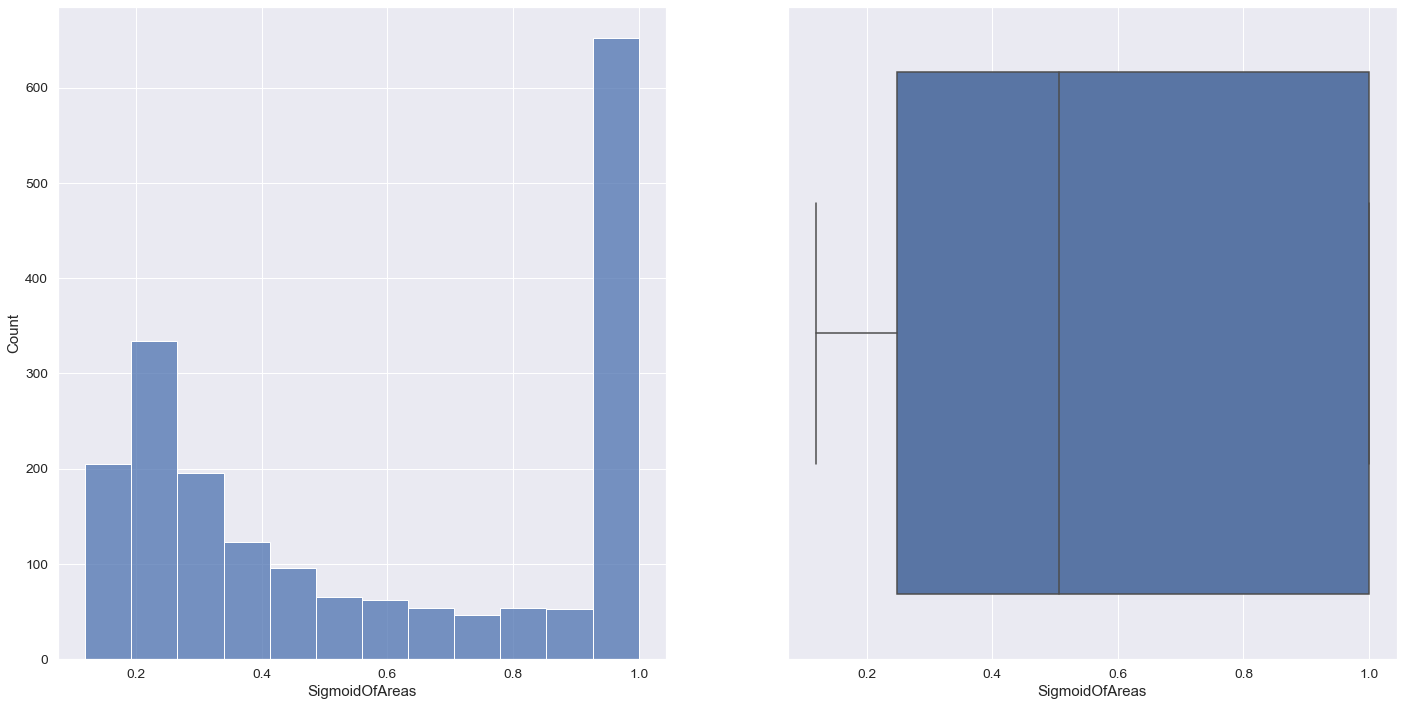

In [161]:
column_insight(steel_features["SigmoidOfAreas"])

1) Признаки X_Minimum, Y_Minimum, X_Maximum, Y_Maximum, X_Perimeter, Y_Perimeter связаны между собой физическим смыслом, вероятно содержат информацию о величине кривизны. Причем некоторые объекты выбиваются из общего ряда из-за крайне высоких значений разностей (X_Maximum-X_Minimum) или (Y_Maximum-Y_Minimum) или же признака X_Perimeter (Y_Perimeter).
2) Признаки "Typeofsteel" - бинарные (описывают марку стали A300/A400). Признак Length_of_Conveyer дискретный (длина конвеера), имеет 2 моды. Одна часть конвееров подлиннее, другая покороче. 
3) Индексные признаки (т.е. в названии содержат Index), признак SigmoidOfAreas имеют ОДЗ или [0; 1] или [-1; 1].
4) Признаки Luminosity_Index, Log_Y_Index, Log_X_Index (возможно двухмодальный), LogOfAreas (возможно двухмодальный), Outside_X_Index, Maximum_of_Luminosity, Minimum_of_Luminosity имеют похожее на нормальное распределения.
5) Признаки Edges_Index, Steel_Plate_Thickness, Y_maximum, Y_minimum имеют похожее на экспоненциальное распределения.

# Треугольная матрица корреляции для признаков и меток

<AxesSubplot:>

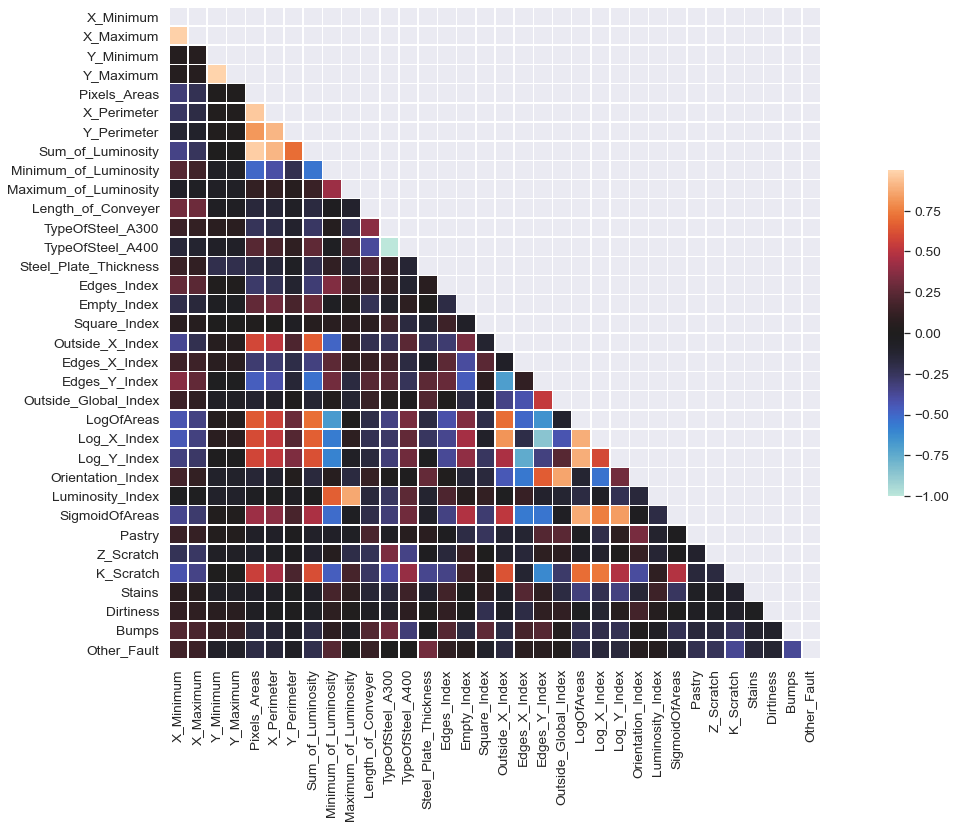

In [162]:
mask = np.triu(np.ones_like(steel_long_names.corr(), dtype=bool))
sns.heatmap(steel_long_names.corr(), mask=mask, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Выделим отдельно для каждой метки несколько признаков с наибольшей и наименьшей (т.е. отрицательной) корреляцией.

In [163]:
sns.set(rc={'figure.figsize':(7,7)})
sns.set(font_scale=1.0)

In [164]:
# Число признаков
n=5

In [165]:
steel_features.corrwith(steel_long_names["Pastry"]).nlargest(n)

Orientation_Index       0.329385
Outside_Global_Index    0.244320
Edges_Y_Index           0.229432
Length_of_Conveyer      0.196209
X_Minimum               0.134956
dtype: float64

<AxesSubplot:>

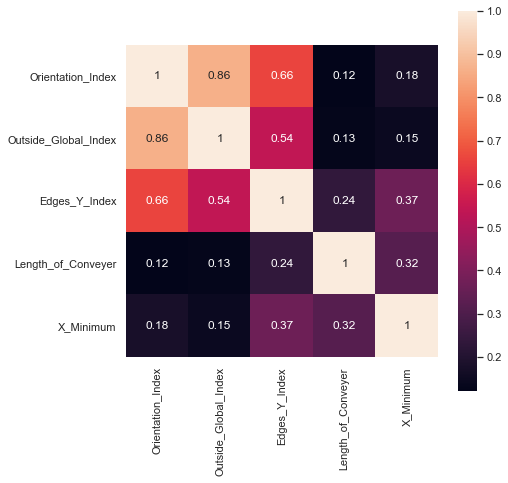

In [166]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Pastry"]).nlargest(n).index.tolist()].corr(), square=True, annot=True)

In [167]:
steel_features.corrwith(steel_long_names["Pastry"]).nsmallest(n)

Square_Index      -0.242923
Log_X_Index       -0.198250
Empty_Index       -0.184993
Outside_X_Index   -0.132081
Edges_X_Index     -0.122428
dtype: float64

<AxesSubplot:>

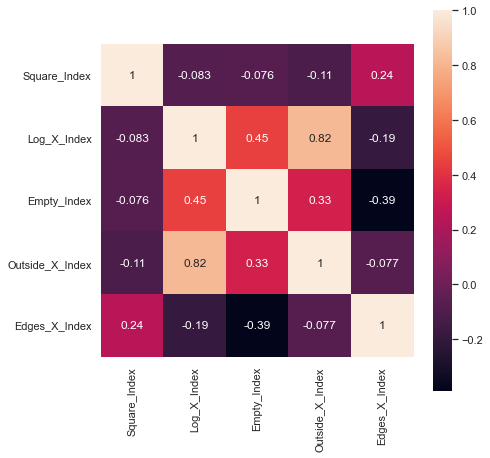

In [168]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Pastry"]).nsmallest(n).index.tolist()].corr(), square=True, annot=True)

In [169]:
steel_features.corrwith(steel_long_names["Z_Scratch"]).nlargest(n)

TypeOfSteel_A300        0.339488
Empty_Index             0.129672
Orientation_Index       0.117501
Edges_Y_Index           0.088045
Outside_Global_Index    0.084885
dtype: float64

<AxesSubplot:>

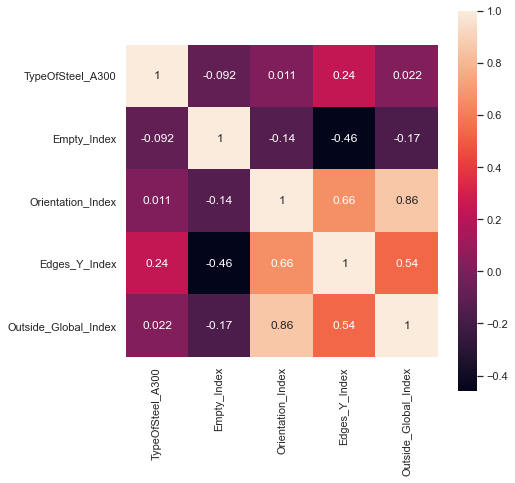

In [170]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Z_Scratch"]).nlargest(n).index.tolist()].corr(), square=True, annot=True)

In [171]:
steel_features.corrwith(steel_long_names["Z_Scratch"]).nsmallest(n)

TypeOfSteel_A400        -0.339488
X_Maximum               -0.258178
Length_of_Conveyer      -0.230856
X_Minimum               -0.228960
Maximum_of_Luminosity   -0.189441
dtype: float64

<AxesSubplot:>

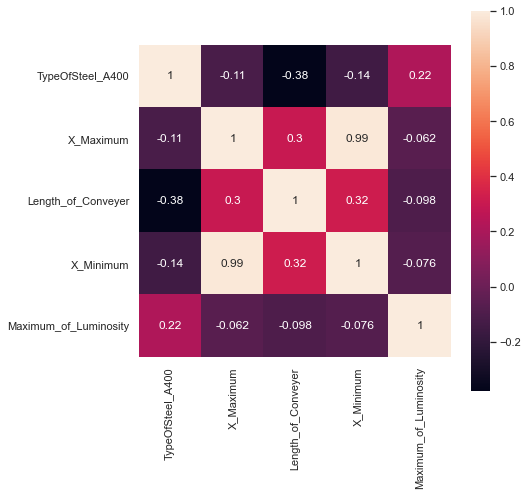

In [172]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Z_Scratch"]).nsmallest(n).index.tolist()].corr(), square=True, annot=True)

In [173]:
steel_features.corrwith(steel_long_names["K_Scratch"]).nlargest(n)

Log_X_Index          0.735860
LogOfAreas           0.704531
Outside_X_Index      0.631370
Sum_of_Luminosity    0.616950
Pixels_Areas         0.556846
dtype: float64

<AxesSubplot:>

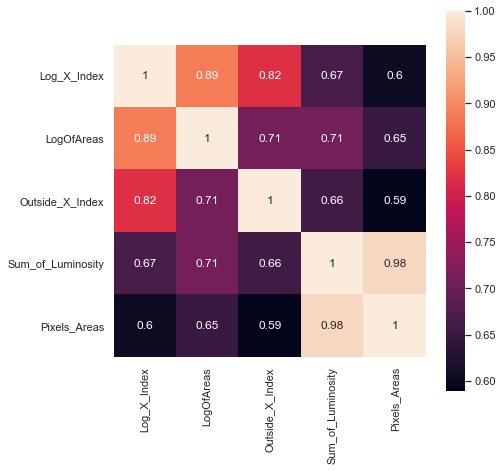

In [174]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["K_Scratch"]).nlargest(n).index.tolist()].corr(), square=True, annot=True)

In [175]:
steel_features.corrwith(steel_long_names["K_Scratch"]).nsmallest(n)

Edges_Y_Index           -0.614341
Minimum_of_Luminosity   -0.461000
X_Minimum               -0.419264
TypeOfSteel_A300        -0.407730
Orientation_Index       -0.384696
dtype: float64

<AxesSubplot:>

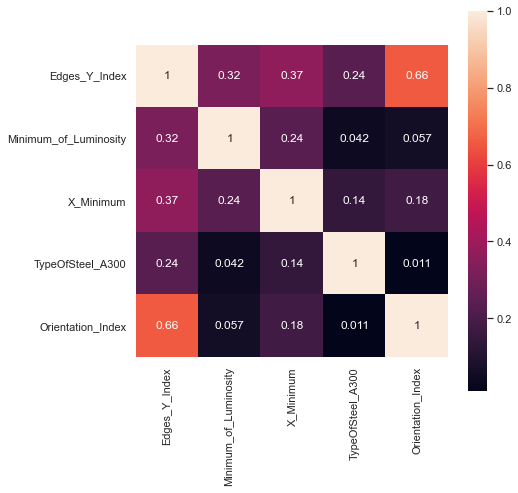

In [176]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["K_Scratch"]).nsmallest(n).index.tolist()].corr(), square=True, annot=True)

In [177]:
steel_features.corrwith(steel_long_names["Stains"]).nlargest(n)

Edges_X_Index            0.229406
Minimum_of_Luminosity    0.183327
Edges_Index              0.165732
TypeOfSteel_A400         0.154796
Luminosity_Index         0.154319
dtype: float64

<AxesSubplot:>

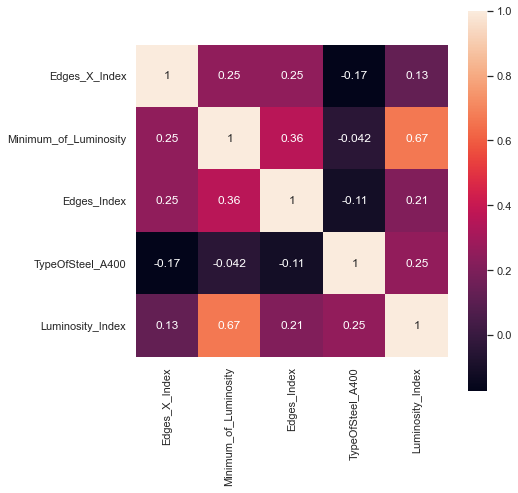

In [178]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Stains"]).nlargest(n).index.tolist()].corr(), square=True, annot=True)

In [179]:
steel_features.corrwith(steel_long_names["Stains"]).nsmallest(n)

Log_Y_Index            -0.321185
LogOfAreas             -0.312690
SigmoidOfAreas         -0.252488
Log_X_Index            -0.212375
Outside_Global_Index   -0.177802
dtype: float64

<AxesSubplot:>

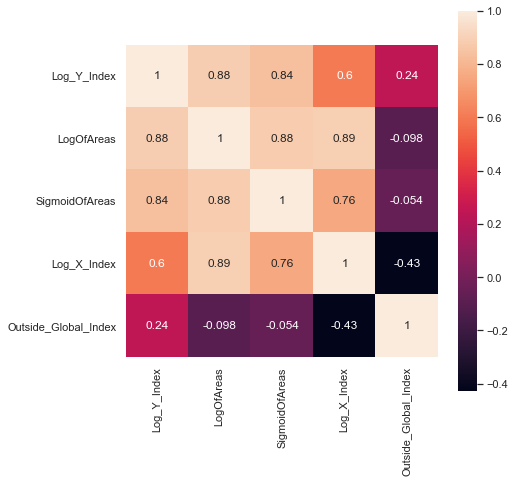

In [180]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Stains"]).nsmallest(n).index.tolist()].corr(), square=True, annot=True)

In [181]:
steel_features.corrwith(steel_long_names["Dirtiness"]).nlargest(n)

Orientation_Index       0.174628
Outside_Global_Index    0.105173
X_Minimum               0.103924
Edges_Index             0.103517
Edges_Y_Index           0.096862
dtype: float64

<AxesSubplot:>

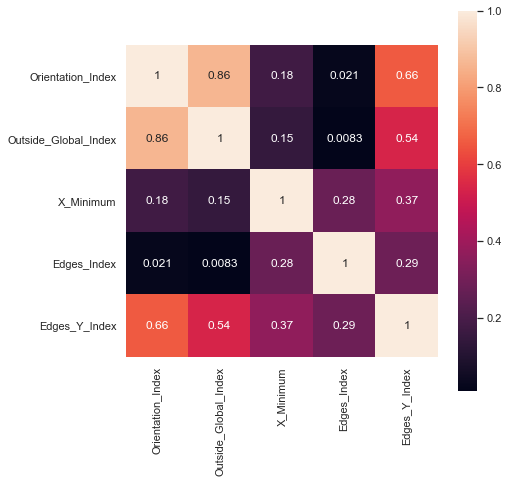

In [182]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Dirtiness"]).nlargest(n).index.tolist()].corr(), square=True, annot=True)

In [183]:
steel_features.corrwith(steel_long_names["Dirtiness"]).nsmallest(n)

Square_Index       -0.214369
Edges_X_Index      -0.180588
Log_X_Index        -0.120561
TypeOfSteel_A300   -0.082489
Outside_X_Index    -0.074105
dtype: float64

<AxesSubplot:>

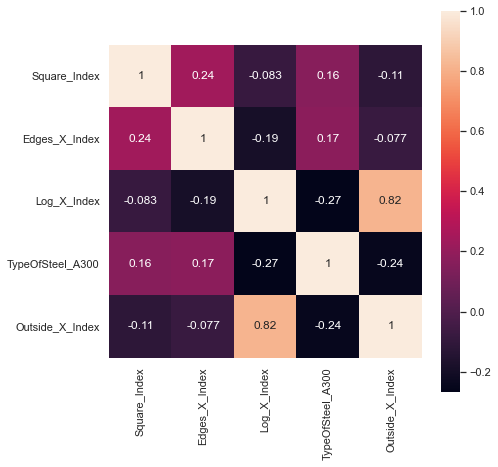

In [184]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Dirtiness"]).nsmallest(n).index.tolist()].corr(), square=True, annot=True)

In [185]:
steel_features.corrwith(steel_long_names["Bumps"]).nlargest(n)

TypeOfSteel_A300      0.306385
Square_Index          0.261385
Edges_Index           0.232000
Edges_Y_Index         0.229231
Length_of_Conveyer    0.225504
dtype: float64

<AxesSubplot:>

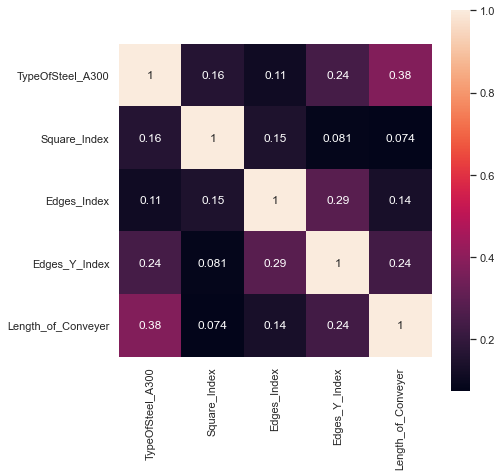

In [186]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Bumps"]).nlargest(n).index.tolist()].corr(), square=True, annot=True)

In [187]:
steel_features.corrwith(steel_long_names["Bumps"]).nsmallest(n)

TypeOfSteel_A400   -0.306385
LogOfAreas         -0.226490
Log_Y_Index        -0.221813
SigmoidOfAreas     -0.220091
Log_X_Index        -0.198690
dtype: float64

<AxesSubplot:>

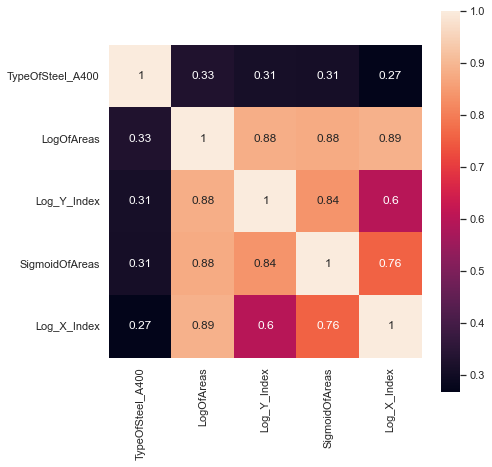

In [188]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Bumps"]).nsmallest(n).index.tolist()].corr(), square=True, annot=True)

In [189]:
steel_features.corrwith(steel_long_names["Other_Fault"]).nlargest(n)

Steel_Plate_Thickness    0.315671
Minimum_of_Luminosity    0.228112
X_Minimum                0.164804
X_Maximum                0.145783
Length_of_Conveyer       0.132091
dtype: float64

<AxesSubplot:>

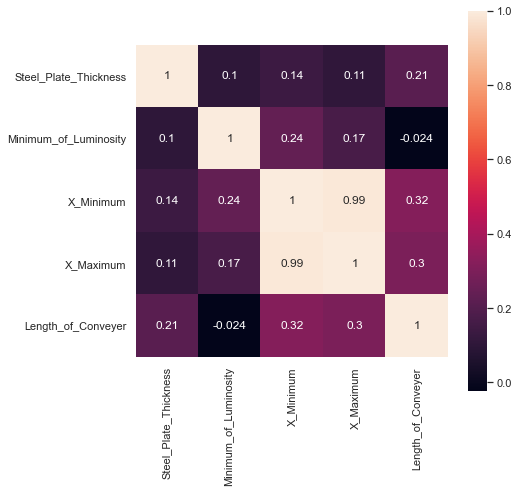

In [190]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Other_Fault"]).nlargest(n).index.tolist()].corr(), square=True, annot=True)

In [191]:
steel_features.corrwith(steel_long_names["Other_Fault"]).nsmallest(n)

Sum_of_Luminosity   -0.205890
LogOfAreas          -0.193121
Pixels_Areas        -0.184632
Outside_X_Index     -0.166709
Log_Y_Index         -0.161769
dtype: float64

<AxesSubplot:>

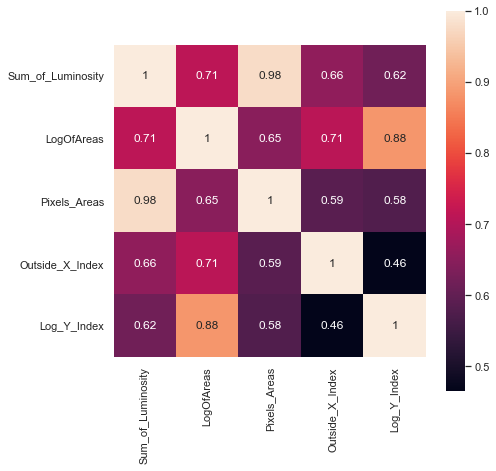

In [192]:
sns.heatmap(data=steel_features[steel_features.corrwith(steel_long_names["Other_Fault"]).nsmallest(n).index.tolist()].corr(), square=True, annot=True)